In [12]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from functools import partial
import math
from utils import set_plots_size_params
import pyabc
import os
import scipy.stats as st
import pandas as pd
import subprocess
import time

In [13]:
def wf_with_selection_and_mutation(wt_freq, population_size, fitness, mutation_rate):
    # math from https://academic.oup.com/sysbio/article/66/1/e30/2670014#syw056M2 
    # Note that the order of selectiona and mutation is relevant to the results.
    wt_freq = (wt_freq * fitness) / ( (1-wt_freq) + (wt_freq * fitness))                 # selection
    wt_freq = wt_freq*(1 - mutation_rate) + (1 - wt_freq)*mutation_rate                  # mutation
    wt_freq = np.random.binomial(population_size, wt_freq) / population_size             # bottleneck
    return wt_freq

    
def wt_generations(generations_number, wt_freq, population_size, fitness, mutation_rate, sequence_sample_size, 
                   color=None, label=None, plot=True):
    freqs = [wt_freq]
    for i in range(generations_number-1):
        wt_freq = wf_with_selection_and_mutation(wt_freq=wt_freq, population_size=population_size, 
                                                 fitness=fitness, mutation_rate=mutation_rate)
        freqs.append(wt_freq)
    freqs = np.random.binomial(sequence_sample_size, freqs) / sequence_sample_size   # sequence sampling
    if plot:
        plt.plot(range(generations_number), freqs, color=color, label=label, alpha=0.1)
    return np.array(freqs)


def simulate_data(generations_number, wt_freqs, population_size, fitness, mutation_rate, sequence_sample_size, 
                  color=None, label=None, plot=True, data_size=10):
    if plot:
        plt.xlabel('Generation')
        plt.ylabel('Frequency')
    data = []
    if label is None:
        label = f"w={fitness}, mu={mutation_rate}"
    first_run = True
    for freq in wt_freqs:
        datum = wt_generations(generations_number=generations_number, wt_freq=freq, plot=plot,
                               population_size=population_size, fitness=fitness, mutation_rate=mutation_rate, 
                               color=color,  sequence_sample_size=sequence_sample_size, 
                               label=label if first_run else None)
        data.append(datum)
        first_run = False
    if plot:
        leg = plt.legend()
        for lh in leg.legendHandles: 
            lh.set_alpha(1)
    return pd.DataFrame(data)

In [41]:
def smc_model(parameters, intial_freqs, data_size):
    pop_size = 100000000
    gen_num = 10
    sample_size = 10**parameters['sample_size']
    mutation_rate = 10**parameters['mu']
    fitness = parameters['w']
    return {'a': simulate_data(generations_number=gen_num,  wt_freqs=intial_freqs, population_size=pop_size, 
                               mutation_rate=mutation_rate, fitness=fitness, sequence_sample_size=sample_size, 
                               plot=False, color=False, label=False, data_size=data_size)}



def L1_X_STD(simulation, data):
    stdiff = abs(data['a'].std() - simulation['a'].std()).sum()
    diff_sum = abs(data['a'] - simulation['a']).sum().sum()
    return diff_sum * stdiff


    
def run_smc(priors, data, epsilon, max_episodes, smc_population_size, multi_data=False):
    start = time.time()
    model = partial(smc_model, intial_freqs=data[0], data_size=len(data))
    model.__name__ = 'model with params'  # pyABC needs this for some reason...
    abc = pyabc.ABCSMC(
            model, priors, L1_X_STD, smc_population_size)
    db_path = ("sqlite:///test.db")
    smc_post = abc.new(db_path, {'a': data})
    smc_post = abc.run(minimum_epsilon=epsilon, max_nr_populations=max_episodes)
    print("SMC run time: ", round(time.time()-start,2))
    print("Total number of SMC simulations: ", smc_post.total_nr_simulations)
    return smc_post

In [42]:
def plot_2d_kde(post, ax, real_w, real_mu):
    df, weights = post.get_distribution()
    df['weights'] = weights
    sns.kdeplot(data=df, x='mu', y='w', weights='weights', ax=ax)
    ax.plot(real_mu, real_w, marker='o', color='red')
    ax.set_ylim([-0.2,2.2])
    ax.set_xlim([-7.5, -3.5])
    

def plot_post_graphs(post, real_mu, real_w, real_ss):
    _, arr_ax = plt.subplots(3, 2)
    pyabc.visualization.plot_epsilons(post, ax=arr_ax[0][1], scale='log10')
    pyabc.visualization.plot_credible_intervals(
        post, par_names=['w'], refval={'w': real_w}, refval_color='gray',show_mean=True, arr_ax=arr_ax[0][0])
    pyabc.visualization.plot_credible_intervals(
        post, par_names=['mu'], refval={'mu': real_mu}, refval_color='gray',show_mean=True, arr_ax=arr_ax[1][0])
    pyabc.visualization.plot_credible_intervals(
        post, par_names=['sample_size'], refval={'sample_size': real_ss}, refval_color='gray',
        show_mean=True, arr_ax=arr_ax[2][0])
    pyabc.visualization.plot_effective_sample_sizes(post, labels=['w'], ax=arr_ax[1][1])
    pyabc.visualization.plot_sample_numbers_trajectory(post, ax=arr_ax[2][1])
    plt.gcf().set_size_inches((12, 8))
    plt.gcf().tight_layout()
    

def infer_avg_50(data, mutation_rate, fitness, epsilon=0.005, max_episodes=10, w_prior=(0,2), mu_prior=(-7,5),
                 smc_population_size=1000):
    data = data.mean()
    prior_dist = pyabc.Distribution(w=pyabc.RV("uniform", w_prior[0], w_prior[1]), 
                                    mu=pyabc.RV("uniform", mu_prior[0], mu_prior[1]))
    print(f"Trying to infer mutation rate {mutation_rate} and fitness {fitness}")
    smc_out = run_smc(prior_dist, data, epsilon, max_episodes, smc_population_size)
    plot_post_graphs(smc_out, mutation_rate, fitness)
    return smc_out 



def infer_megadist(data, mutation_rate, fitness, epsilon=0.005, max_episodes=10, w_prior=(0,2), mu_prior=(-7,5),
                   smc_population_size=1000):
    prior_dist = pyabc.Distribution(w=pyabc.RV("uniform", w_prior[0], w_prior[1]), 
                                    mu=pyabc.RV("uniform", mu_prior[0], mu_prior[1]),
                                    data_size=pyabc.RV("uniform", len(data),0.1))
    print(f"Trying to infer mutation rate {mutation_rate} and fitness {fitness}")
    smc_out = run_smc(prior_dist, data, epsilon, max_episodes, smc_population_size, multi_data=True)
    plot_post_graphs(smc_out, mutation_rate, fitness)
    return smc_out 


In [43]:
def plot_2d_kde_from_df(df, real_w, real_mu, ax, title):
    sns.kdeplot(data=df, x='mu', y='w', weights='weights', ax=ax)
    ax.plot(real_mu, real_w, marker='o', color='red')
    ax.set_ylim([-0.2,2.2])
    ax.set_xlim([-7.5, -3.5])
    ax.set_title(title)


def infer_megapost(mutation_rate, fitness, data, epsilon=0.005, max_episodes=10, w_prior=(0,2), mu_prior=(-7,5),
                   smc_population_size=1000):
    prior_dist = pyabc.Distribution(w=pyabc.RV("uniform", w_prior[0], w_prior[1]), 
                                    mu=pyabc.RV("uniform", mu_prior[0], mu_prior[1]))
    print(f"Trying to infer mutation rate {mutation_rate} and fitness {fitness}")
    smc_out = pd.DataFrame()
    for i, row in data.iterrows():
        smc_run = run_smc(prior_dist, row, epsilon, max_episodes, smc_population_size )
        df, weights = smc_run.get_distribution()
        df['weights'] = weights
        smc_out = pd.concat([smc_out, df])
    plot_2d_kde_from_df(smc_out, fitness, mutation_rate)
    return smc_out 


def plot_kdes(fitness, mutation_rate, avg, megadist, megapost):
    fig, axes = plt.subplots(1, 3)
    plot_2d_kde_from_df(avg, fitness, mutation_rate, axes[0], 'Avged Input')
    plot_2d_kde_from_df(megadist, fitness, mutation_rate, axes[1], 'Mega Distance Function')
    plot_2d_kde_from_df(megapost, fitness, mutation_rate, axes[2], 'Mega Posterior')
    plt.gcf().set_size_inches((12, 4))
    plt.gcf().tight_layout()



def compare_methods(mutation_rate, fitness, sample_size, epsilon=0.005, max_episodes=10, w_prior=(0,2), mu_prior=(-7,5),
                    ss_prior=(2,6), smc_population_size=1000, data_size=1, wt_freqs=[0]):
    params = {'gen': 10, 'pop': 100000000}
    print("Creating dataset...")
    if wt_freqs=='random':
        wt_freqs = np.random.uniform(0,0.1, data_size)
    data_size = len(wt_freqs)
    data = simulate_data(generations_number=params['gen'], wt_freqs=wt_freqs,  mutation_rate=10**mutation_rate,
                         population_size=params['pop'], fitness=fitness, sequence_sample_size=10**sample_size, 
                         plot=False, data_size=data_size)
    prior_dist = pyabc.Distribution(w=pyabc.RV("uniform", w_prior[0], w_prior[1]), 
                                    mu=pyabc.RV("uniform", mu_prior[0], mu_prior[1]),
                                    sample_size=pyabc.RV("uniform", ss_prior[0],ss_prior[1]))
    print("Inferring from avgs")
    #avg_post = run_smc(priors=prior_dist, data=data.mean(), epsilon=epsilon, max_episodes=max_episodes, 
    #                   smc_population_size=smc_population_size)
    #plot_post_graphs(avg_post, mutation_rate, fitness, sample_size)
    print("Inferring with mega distance function")
    mega_post = run_smc(priors=prior_dist, data=data, epsilon=data_size*epsilon, max_episodes=max_episodes, 
                        smc_population_size=smc_population_size, multi_data=True)
    plot_post_graphs(mega_post, mutation_rate, fitness, sample_size)
    return mega_post #{'avg': avg_post, 'megadist': mega_post}

In [ ]:
# for a good estimate of sample size we need to look at the higher frequencies.
gens = 10
ps = 10 ** 8
mu = 10 ** -4
ss = 10 ** 3

simulate_data(generations_number=gens, wt_freqs=np.zeros(10), population_size=ps, fitness=1.0, mutation_rate=mu, 
              sequence_sample_size=ss, color='black', label=None, plot=True)
simulate_data(generations_number=gens, wt_freqs=0.01*np.ones(10), population_size=ps, fitness=1.0, mutation_rate=mu, 
              sequence_sample_size=ss, color='blue', label=None, plot=True)
simulate_data(generations_number=gens, wt_freqs=0.05*np.ones(10), population_size=ps, fitness=1, mutation_rate=mu, 
              sequence_sample_size=ss, color='green', label=None, plot=True)

plt.title(f'{ss} Sequenced Virions')

In [44]:
post = compare_methods(-4, 1.3, 5, 0.00000001, wt_freqs=[0, 0], max_episodes=10)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=354, start_time=2021-03-10 19:06:35.716360, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring from avgs
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 1.0057957566275567e-05
INFO:ABC:t: 0, eps: 1.0057957566275567e-05.
INFO:ABC:Acceptance rate: 1000 / 1731 = 5.7770e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 9.560295624794177e-06.
INFO:ABC:Acceptance rate: 1000 / 2031 = 4.9237e-01, ESS=8.6041e+02.
INFO:ABC:t: 2, eps: 7.826174357250935e-06.
INFO:ABC:Acceptance rate: 1000 / 2357 = 4.2427e-01, ESS=7.9141e+02.
INFO:ABC:t: 3, eps: 5.969621424413202e-06.
INFO:ABC:Acceptance rate: 1000 / 2438 = 4.1017e-01, ESS=8.9898e+02.
INFO:ABC:t: 4, eps: 4.489171331104557e-06.
INFO:ABC:Acceptance rate: 1000 / 2459 = 4.0667e-01, ESS=8.6207e+02.
INFO:ABC:t: 5, eps: 3.3893104243200027e-06.
INFO:ABC:Acceptance rate: 1000 / 2490 = 4.0161e-01, ESS=8.6433e+02.
INFO:ABC:t: 6, eps: 2.6009314296568096e-06.
INFO:ABC:Acceptance rate: 1000 / 2404 = 4.1597e-01, ESS=9.0909e+02.
INFO:ABC:t: 7, eps: 1.894157145141331e-06.
INFO:ABC:Acceptance rate: 1000 / 2276 = 4.3937e-01, ESS=8.3185e+02.
INFO:ABC:t: 8, eps: 1.4224217940755145e-06.


KeyboardInterrupt: 

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=342, start_time=2021-03-10 18:39:01.402712, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring from avgs
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.0017190818601665048
INFO:ABC:t: 0, eps: 0.0017190818601665048.
INFO:ABC:Acceptance rate: 1000 / 2089 = 4.7870e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.0013333162559656454.
INFO:ABC:Acceptance rate: 1000 / 2243 = 4.4583e-01, ESS=9.0617e+02.
INFO:ABC:t: 2, eps: 0.0009079056171106773.
INFO:ABC:Acceptance rate: 1000 / 2538 = 3.9401e-01, ESS=9.0882e+02.
INFO:ABC:t: 3, eps: 0.0004797100191451903.
INFO:ABC:Acceptance rate: 1000 / 2285 = 4.3764e-01, ESS=9.3440e+02.
INFO:ABC:t: 4, eps: 0.0002441735449174813.
INFO:ABC:Acceptance rate: 1000 / 2166 = 4.6168e-01, ESS=9.2540e+02.
INFO:ABC:t: 5, eps: 0.00012772554445960124.
INFO:ABC:Acceptance rate: 1000 / 2227 = 4.4903e-01, ESS=9.4185e+02.
INFO:ABC:t: 6, eps: 7.601767507516024e-05.
INFO:ABC:Acceptance rate: 1000 / 2242 = 4.4603e-01, ESS=9.1398e+02.
INFO:ABC:t: 7, eps: 6.0352377228398117e-05.
INFO:ABC:Acceptance rate: 1000 / 2540 = 3.9370e-01, ESS=6.4635e+02.
INFO:ABC:t: 8, eps: 4.557202393137856e-05.
INFO:ABC:Acce

SMC run time:  60.24
Total number of SMC simulations:  24411


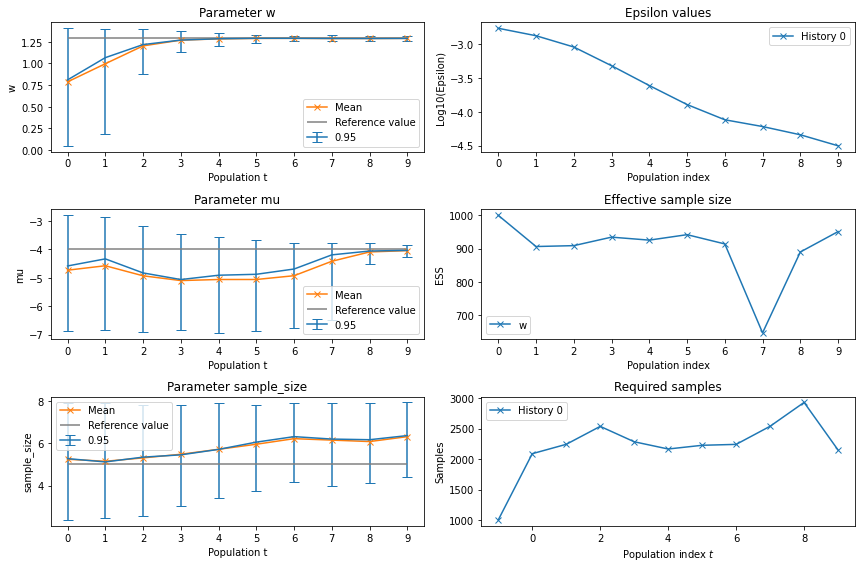

In [23]:
post = compare_methods(-4, 1.3, 5, 0.00000001, wt_freqs=[0, 0, 0, 0.001], max_episodes=10)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=346, start_time=2021-03-10 18:48:36.728894, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring from avgs
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 3.286891215031649
INFO:ABC:t: 0, eps: 3.286891215031649.
INFO:ABC:Acceptance rate: 1000 / 1976 = 5.0607e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 1.531050799790901.
INFO:ABC:Acceptance rate: 1000 / 2038 = 4.9068e-01, ESS=9.2623e+02.
INFO:ABC:t: 2, eps: 0.4744218765435455.
INFO:ABC:Acceptance rate: 1000 / 2012 = 4.9702e-01, ESS=9.5495e+02.
INFO:ABC:t: 3, eps: 0.13970396662572074.
INFO:ABC:Acceptance rate: 1000 / 1922 = 5.2029e-01, ESS=8.9764e+02.
INFO:ABC:t: 4, eps: 0.04493938954922879.
INFO:ABC:Acceptance rate: 1000 / 2118 = 4.7214e-01, ESS=9.5790e+02.
INFO:ABC:t: 5, eps: 0.014704668669687154.
INFO:ABC:Acceptance rate: 1000 / 2174 = 4.5998e-01, ESS=9.3404e+02.
INFO:ABC:t: 6, eps: 0.005448068983707997.
INFO:ABC:Acceptance rate: 1000 / 2126 = 4.7037e-01, ESS=9.4336e+02.
INFO:ABC:t: 7, eps: 0.0020017217217733574.
INFO:ABC:Acceptance rate: 1000 / 2120 = 4.7170e-01, ESS=9.3071e+02.
INFO:ABC:t: 8, eps: 0.0009347713736194862.
INFO:ABC:Acceptance rate: 1000 / 209

SMC run time:  62.59
Total number of SMC simulations:  21768


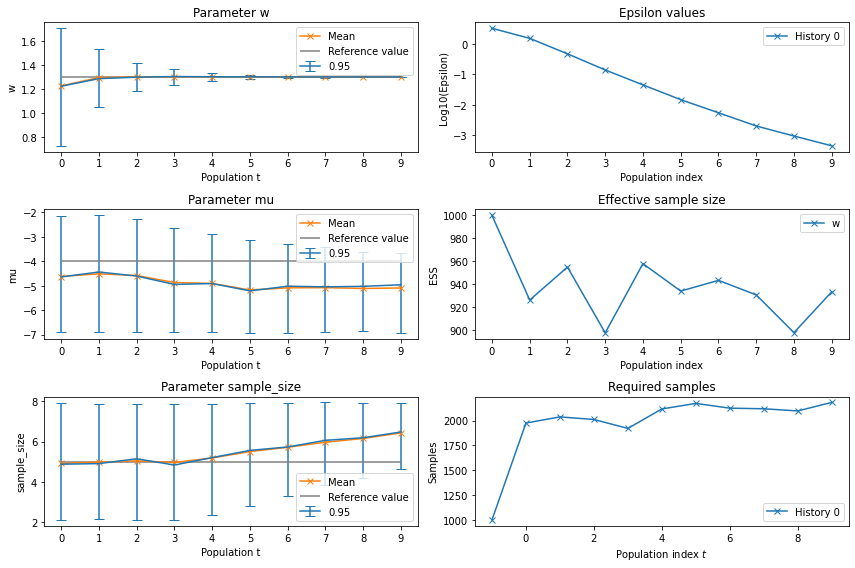

In [27]:
post = compare_methods(-4, 1.3, 5, 0.00000001, wt_freqs=[0, 0, 0, 0.1], max_episodes=10)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=345, start_time=2021-03-10 18:45:32.379262, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring from avgs
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.0006040061007380683
INFO:ABC:t: 0, eps: 0.0006040061007380683.
INFO:ABC:Acceptance rate: 1000 / 1996 = 5.0100e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.000281997883190424.
INFO:ABC:Acceptance rate: 1000 / 2120 = 4.7170e-01, ESS=9.1473e+02.
INFO:ABC:t: 2, eps: 0.00018813106509005131.
INFO:ABC:Acceptance rate: 1000 / 2289 = 4.3687e-01, ESS=9.2131e+02.
INFO:ABC:t: 3, eps: 0.00013967220670303357.
INFO:ABC:Acceptance rate: 1000 / 2903 = 3.4447e-01, ESS=6.1283e+02.
INFO:ABC:t: 4, eps: 0.00011608915143531793.
INFO:ABC:Acceptance rate: 1000 / 3573 = 2.7988e-01, ESS=8.3264e+02.
INFO:ABC:t: 5, eps: 9.55101293071002e-05.
INFO:ABC:Acceptance rate: 1000 / 3563 = 2.8066e-01, ESS=8.4349e+02.
INFO:ABC:t: 6, eps: 7.09976296094117e-05.
INFO:ABC:Acceptance rate: 1000 / 2579 = 3.8775e-01, ESS=8.7769e+02.
INFO:ABC:t: 7, eps: 5.192455434758457e-05.
INFO:ABC:Acceptance rate: 1000 / 2394 = 4.1771e-01, ESS=8.7847e+02.
INFO:ABC:t: 8, eps: 3.998370096418274e-05.
INFO:ABC:Accept

SMC run time:  143.55
Total number of SMC simulations:  83830


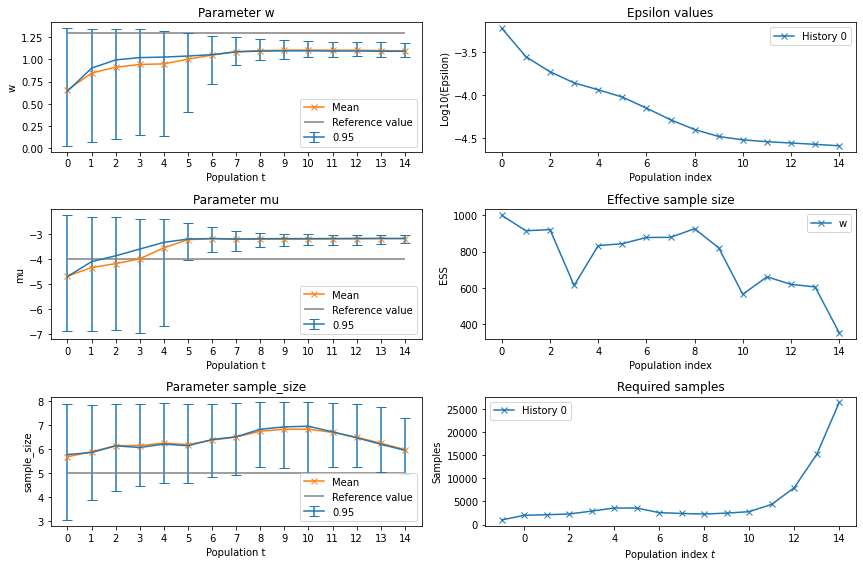

In [26]:
post = compare_methods(-4, 1.3, 5, 0.00000001, wt_freqs=[0.001, 0.001, 0.001, 0.001], max_episodes=15)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=355, start_time=2021-03-10 19:07:27.297836, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring from avgs
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.0002338093232482367
INFO:ABC:t: 0, eps: 0.0002338093232482367.
INFO:ABC:Acceptance rate: 1000 / 1983 = 5.0429e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00012514188371369063.
INFO:ABC:Acceptance rate: 1000 / 2012 = 4.9702e-01, ESS=9.0904e+02.
INFO:ABC:t: 2, eps: 8.38383125892214e-05.
INFO:ABC:Acceptance rate: 1000 / 2601 = 3.8447e-01, ESS=8.9598e+02.
INFO:ABC:t: 3, eps: 6.400802348787366e-05.
INFO:ABC:Acceptance rate: 1000 / 3955 = 2.5284e-01, ESS=8.5379e+02.
INFO:ABC:t: 4, eps: 4.9009676036484135e-05.
INFO:ABC:Acceptance rate: 1000 / 5889 = 1.6981e-01, ESS=7.0480e+02.
INFO:ABC:t: 5, eps: 3.732601373570547e-05.
INFO:ABC:Acceptance rate: 1000 / 6989 = 1.4308e-01, ESS=7.7144e+02.
INFO:ABC:t: 6, eps: 2.7917509877226832e-05.
INFO:ABC:Acceptance rate: 1000 / 6602 = 1.5147e-01, ESS=8.4628e+02.
INFO:ABC:t: 7, eps: 2.241727483763613e-05.
INFO:ABC:Acceptance rate: 1000 / 7497 = 1.3339e-01, ESS=6.0947e+02.
INFO:ABC:t: 8, eps: 1.8444823332822392e-05.
INFO:ABC:Acc

SMC run time:  112.32
Total number of SMC simulations:  69209


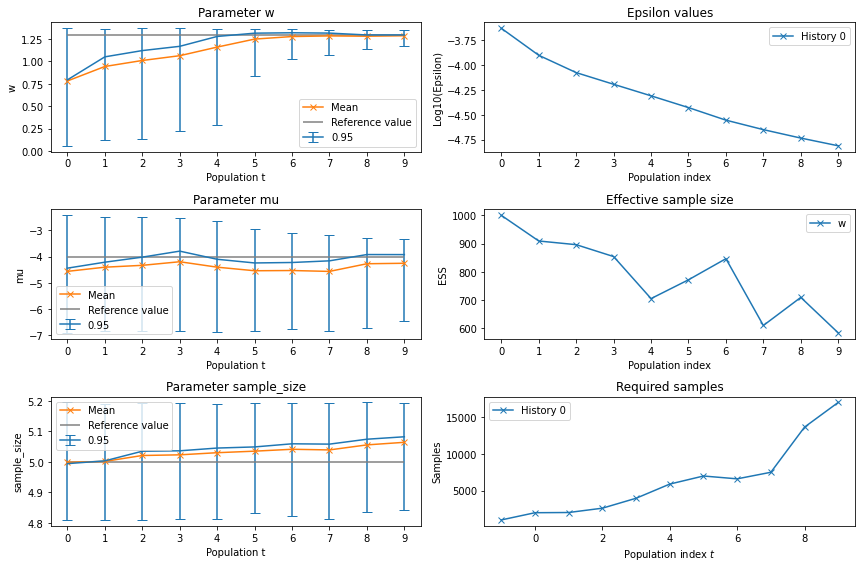

In [45]:
post = compare_methods(-4, 1.3, 5, 0.00000001, wt_freqs=[0.001, 0.001, 0.001, 0.001], ss_prior=(4.8,0.4), 
                       max_episodes=10)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=351, start_time=2021-03-10 18:57:34.859568, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring from avgs
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.01310400435494522
INFO:ABC:t: 0, eps: 0.01310400435494522.
INFO:ABC:Acceptance rate: 1000 / 2047 = 4.8852e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.007668980018848596.
INFO:ABC:Acceptance rate: 1000 / 2187 = 4.5725e-01, ESS=9.1510e+02.
INFO:ABC:t: 2, eps: 0.004208963369077189.
INFO:ABC:Acceptance rate: 1000 / 2257 = 4.4307e-01, ESS=8.9611e+02.
INFO:ABC:t: 3, eps: 0.0022703961413949687.
INFO:ABC:Acceptance rate: 1000 / 2479 = 4.0339e-01, ESS=9.0710e+02.
INFO:ABC:t: 4, eps: 0.0014306396179227375.
INFO:ABC:Acceptance rate: 1000 / 2734 = 3.6576e-01, ESS=9.2621e+02.
INFO:ABC:t: 5, eps: 0.0008955583939302962.
INFO:ABC:Acceptance rate: 1000 / 2705 = 3.6969e-01, ESS=9.3107e+02.
INFO:ABC:t: 6, eps: 0.000529708955357917.
INFO:ABC:Acceptance rate: 1000 / 2773 = 3.6062e-01, ESS=9.0216e+02.
INFO:ABC:t: 7, eps: 0.00040014934839955485.
INFO:ABC:Acceptance rate: 1000 / 3169 = 3.1556e-01, ESS=7.4119e+02.
INFO:History:Done <ABCSMC(id=351, start_time=2021-03-10 18:57:34

SMC run time:  104.35
Total number of SMC simulations:  21351


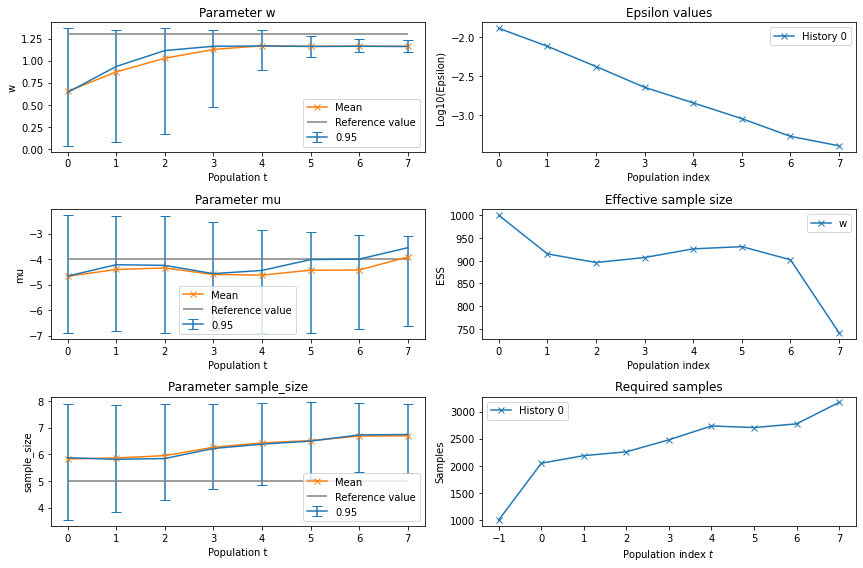

In [36]:
post = compare_methods(-4, 1.3, 5, 0.00000001, wt_freqs=list(0.001*np.ones(100)), max_episodes=8)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=353, start_time=2021-03-10 19:01:40.321732, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring from avgs
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.2075862963833684
INFO:ABC:t: 0, eps: 0.2075862963833684.
INFO:ABC:Acceptance rate: 1000 / 1880 = 5.3191e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.17478171504569973.
INFO:ABC:Acceptance rate: 1000 / 2231 = 4.4823e-01, ESS=8.9458e+02.
INFO:ABC:t: 2, eps: 0.12305915803651774.
INFO:ABC:Acceptance rate: 1000 / 2543 = 3.9324e-01, ESS=9.3586e+02.
INFO:ABC:t: 3, eps: 0.09006708861526201.
INFO:ABC:Acceptance rate: 1000 / 2770 = 3.6101e-01, ESS=9.4780e+02.
INFO:ABC:t: 4, eps: 0.059716098699693416.
INFO:ABC:Acceptance rate: 1000 / 2602 = 3.8432e-01, ESS=9.2670e+02.
INFO:ABC:t: 5, eps: 0.038417017098383376.
INFO:ABC:Acceptance rate: 1000 / 2678 = 3.7341e-01, ESS=9.3060e+02.
INFO:ABC:t: 6, eps: 0.027449552722432997.
INFO:ABC:Acceptance rate: 1000 / 2867 = 3.4880e-01, ESS=8.7752e+02.
INFO:ABC:t: 7, eps: 0.02254345832589694.
INFO:ABC:Acceptance rate: 1000 / 3520 = 2.8409e-01, ESS=7.9808e+02.
INFO:ABC:t: 8, eps: 0.02057430534039271.
INFO:ABC:Acceptance rate: 1000 / 5

SMC run time:  79.55
Total number of SMC simulations:  36996


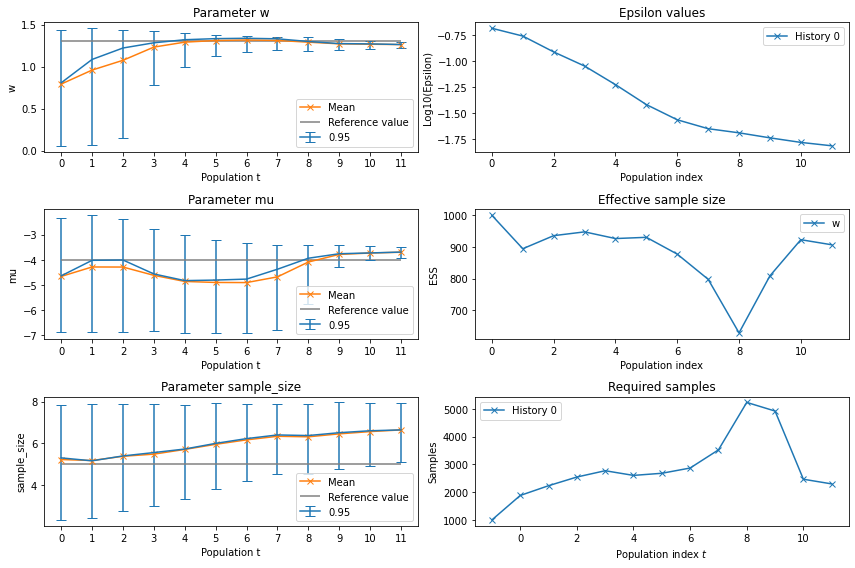

In [39]:
post = compare_methods(-4, 1.3, 5, 0.00000001, wt_freqs=[0.001, 0.001, 0.001, 0.001], max_episodes=12) # no std

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=347, start_time=2021-03-10 18:50:16.685350, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring from avgs
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.0003319662270198154
INFO:ABC:t: 0, eps: 0.0003319662270198154.
INFO:ABC:Acceptance rate: 1000 / 2146 = 4.6598e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00019200647992072465.
INFO:ABC:Acceptance rate: 1000 / 2104 = 4.7529e-01, ESS=8.9303e+02.
INFO:ABC:t: 2, eps: 0.00012004006835121582.
INFO:ABC:Acceptance rate: 1000 / 2296 = 4.3554e-01, ESS=9.2519e+02.
INFO:ABC:t: 3, eps: 7.215294026928468e-05.
INFO:ABC:Acceptance rate: 1000 / 2756 = 3.6284e-01, ESS=9.3363e+02.
INFO:ABC:t: 4, eps: 3.916653323505441e-05.
INFO:ABC:Acceptance rate: 1000 / 2549 = 3.9231e-01, ESS=9.1961e+02.
INFO:ABC:t: 5, eps: 2.193325682390217e-05.
INFO:ABC:Acceptance rate: 1000 / 2286 = 4.3745e-01, ESS=9.2506e+02.
INFO:ABC:t: 6, eps: 1.3043101264510268e-05.
INFO:ABC:Acceptance rate: 1000 / 2281 = 4.3840e-01, ESS=8.7061e+02.
INFO:ABC:t: 7, eps: 7.990079535410948e-06.
INFO:ABC:Acceptance rate: 1000 / 2423 = 4.1271e-01, ESS=9.3286e+02.
INFO:ABC:t: 8, eps: 5.862080917685889e-06.
INFO:ABC:Acc

SMC run time:  65.97
Total number of SMC simulations:  25153


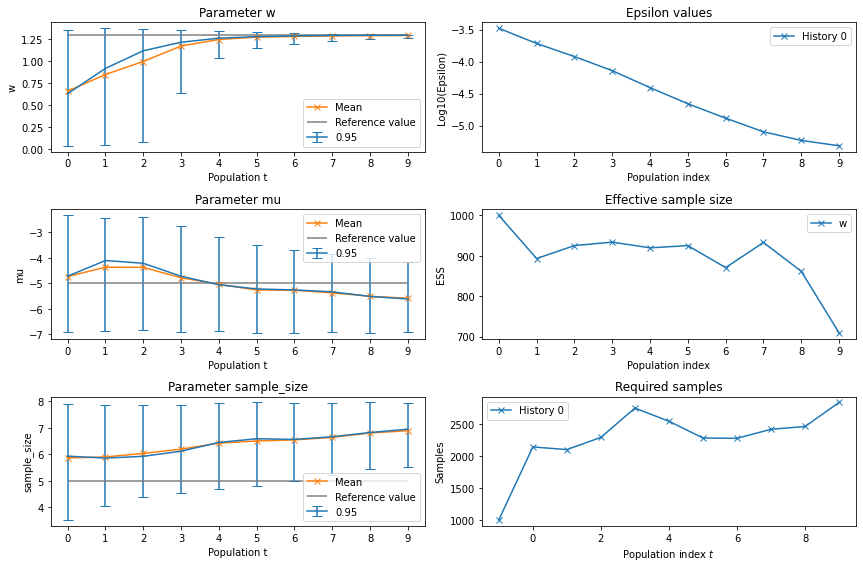

In [28]:
post = compare_methods(-5, 1.3, 5, 0.00000001, wt_freqs=[0.001, 0.001, 0.001, 0.001], max_episodes=10)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=343, start_time=2021-03-10 18:40:46.901504, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring from avgs
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 3.3433808850437967
INFO:ABC:t: 0, eps: 3.3433808850437967.
INFO:ABC:Acceptance rate: 1000 / 1983 = 5.0429e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 1.649136899363808.
INFO:ABC:Acceptance rate: 1000 / 1969 = 5.0787e-01, ESS=8.9765e+02.
INFO:ABC:t: 2, eps: 0.5583770331459572.
INFO:ABC:Acceptance rate: 1000 / 2019 = 4.9529e-01, ESS=9.3310e+02.
INFO:ABC:t: 3, eps: 0.19780246467412002.
INFO:ABC:Acceptance rate: 1000 / 1895 = 5.2770e-01, ESS=8.9983e+02.
INFO:ABC:t: 4, eps: 0.062498942356558874.
INFO:ABC:Acceptance rate: 1000 / 1986 = 5.0352e-01, ESS=9.3458e+02.
INFO:ABC:t: 5, eps: 0.022134382990628268.
INFO:ABC:Acceptance rate: 1000 / 2004 = 4.9900e-01, ESS=9.2933e+02.
INFO:ABC:t: 6, eps: 0.007489318181092269.
INFO:ABC:Acceptance rate: 1000 / 1990 = 5.0251e-01, ESS=9.4186e+02.
INFO:ABC:t: 7, eps: 0.0028710191967368567.
INFO:ABC:Acceptance rate: 1000 / 2101 = 4.7596e-01, ESS=9.3363e+02.
INFO:ABC:t: 8, eps: 0.0012391415777212708.
INFO:ABC:Acceptance rate: 1000 / 

SMC run time:  58.87
Total number of SMC simulations:  21241


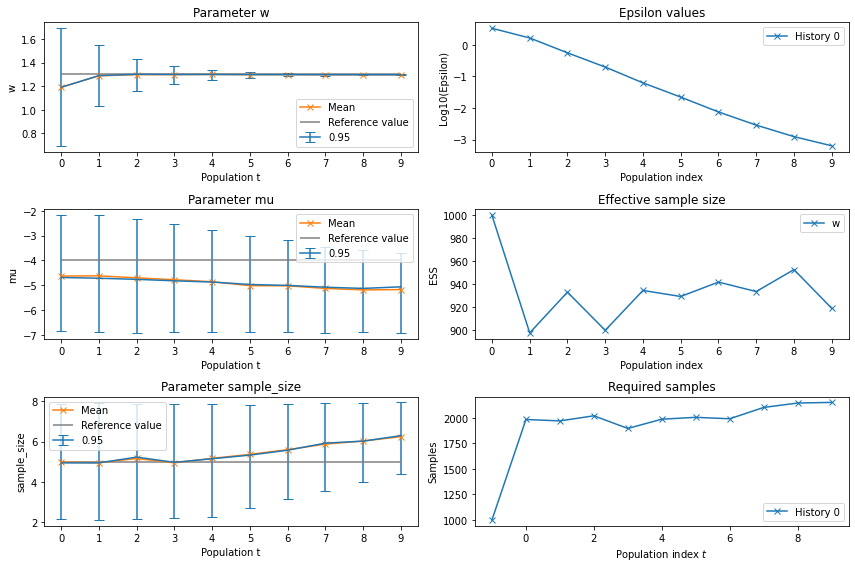

In [24]:
post = compare_methods(-4, 1.3, 5, 0.00000001, wt_freqs=[0, 0, 0, 0.1], max_episodes=10)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=311, start_time=2021-03-10 14:35:35.099392, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring from avgs
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.0003171368923502538
INFO:ABC:t: 0, eps: 0.0003171368923502538.
INFO:ABC:Acceptance rate: 1000 / 2090 = 4.7847e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00027100178226054566.
INFO:ABC:Acceptance rate: 1000 / 2122 = 4.7125e-01, ESS=8.0764e+02.
INFO:ABC:t: 2, eps: 0.0002150550130497687.
INFO:ABC:Acceptance rate: 1000 / 2174 = 4.5998e-01, ESS=7.7983e+02.
INFO:ABC:t: 3, eps: 0.00017828435429876965.
INFO:ABC:Acceptance rate: 1000 / 2498 = 4.0032e-01, ESS=8.2305e+02.
INFO:ABC:t: 4, eps: 0.0001443582604518934.
INFO:ABC:Acceptance rate: 1000 / 2913 = 3.4329e-01, ESS=8.1398e+02.
INFO:ABC:t: 5, eps: 0.00011595606759711775.
INFO:ABC:Acceptance rate: 1000 / 3933 = 2.5426e-01, ESS=7.9025e+02.
INFO:ABC:t: 6, eps: 9.631133330699201e-05.
INFO:ABC:Acceptance rate: 1000 / 6175 = 1.6194e-01, ESS=5.7057e+02.
INFO:ABC:t: 7, eps: 8.238057866286075e-05.
INFO:ABC:Acceptance rate: 1000 / 9347 = 1.0699e-01, ESS=6.5257e+02.
INFO:ABC:t: 8, eps: 7.09859720317769e-05.
INFO:ABC:Acce

SMC run time:  141.58
Total number of SMC simulations:  76638


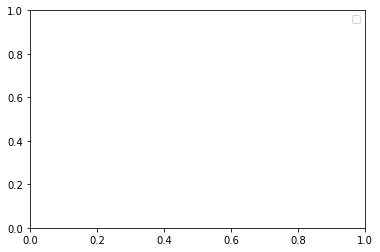

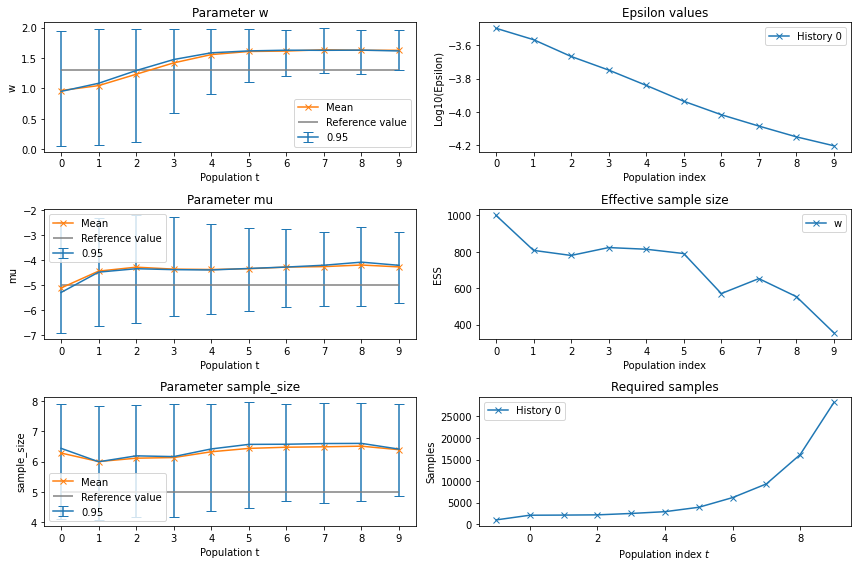

In [108]:
compare_methods(-5, 1.3, 5, 0.00000001, data_size=5) # just stdist

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=310, start_time=2021-03-10 14:32:24.924087, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring from avgs
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.006702391105115323
INFO:ABC:t: 0, eps: 0.006702391105115323.
INFO:ABC:Acceptance rate: 1000 / 2049 = 4.8804e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.005142997922997373.
INFO:ABC:Acceptance rate: 1000 / 2040 = 4.9020e-01, ESS=8.4086e+02.
INFO:ABC:t: 2, eps: 0.004473460519827624.
INFO:ABC:Acceptance rate: 1000 / 2245 = 4.4543e-01, ESS=8.4524e+02.
INFO:ABC:t: 3, eps: 0.00370214265039306.
INFO:ABC:Acceptance rate: 1000 / 2129 = 4.6970e-01, ESS=8.4512e+02.
INFO:ABC:t: 4, eps: 0.0029103300944967603.
INFO:ABC:Acceptance rate: 1000 / 2142 = 4.6685e-01, ESS=8.7573e+02.
INFO:ABC:t: 5, eps: 0.002324237239371491.
INFO:ABC:Acceptance rate: 1000 / 2243 = 4.4583e-01, ESS=8.7904e+02.
INFO:ABC:t: 6, eps: 0.0018892991140853567.
INFO:ABC:Acceptance rate: 1000 / 2227 = 4.4903e-01, ESS=8.8281e+02.
INFO:ABC:t: 7, eps: 0.0016009369678209307.
INFO:ABC:Acceptance rate: 1000 / 2339 = 4.2753e-01, ESS=8.7069e+02.
INFO:ABC:t: 8, eps: 0.0014205720263163735.
INFO:ABC:Acceptance ra

SMC run time:  61.91
Total number of SMC simulations:  23012


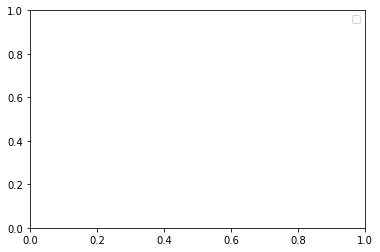

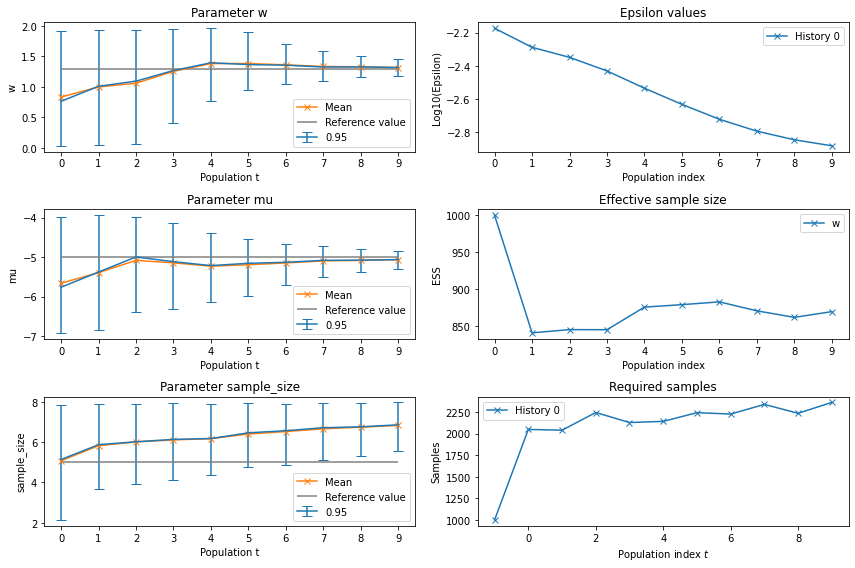

In [104]:
compare_methods(-5, 1.3, 5, 0.00000001, data_size=5) # old_dist

In [ ]:
def distance(simulation, data):
    stdiff = abs(data.std() - simulation.std()).sum()
    old_L1_distance = abs(data - simulation).sum().sum()
    return old_L1_distance * stdiff


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=312, start_time=2021-03-10 14:41:35.532354, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring from avgs
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 2.5208037597604326e-06
INFO:ABC:t: 0, eps: 2.5208037597604326e-06.
INFO:ABC:Acceptance rate: 1000 / 2111 = 4.7371e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 1.2749699248494826e-06.
INFO:ABC:Acceptance rate: 1000 / 1957 = 5.1099e-01, ESS=8.1586e+02.
INFO:ABC:t: 2, eps: 9.037747481135713e-07.
INFO:ABC:Acceptance rate: 1000 / 2264 = 4.4170e-01, ESS=8.9050e+02.
INFO:ABC:t: 3, eps: 6.102958985005721e-07.
INFO:ABC:Acceptance rate: 1000 / 2248 = 4.4484e-01, ESS=8.5339e+02.
INFO:ABC:t: 4, eps: 4.2864022006952093e-07.
INFO:ABC:Acceptance rate: 1000 / 2540 = 3.9370e-01, ESS=8.7993e+02.
INFO:ABC:t: 5, eps: 3.2453028074932374e-07.
INFO:ABC:Acceptance rate: 1000 / 2907 = 3.4400e-01, ESS=8.4674e+02.
INFO:ABC:t: 6, eps: 2.590681247532698e-07.
INFO:ABC:Acceptance rate: 1000 / 3183 = 3.1417e-01, ESS=5.9251e+02.
INFO:ABC:t: 7, eps: 2.1206440867195985e-07.
INFO:ABC:Acceptance rate: 1000 / 3685 = 2.7137e-01, ESS=5.9006e+02.
INFO:ABC:t: 8, eps: 1.7761096079667234e-07.
INFO:ABC

SMC run time:  96.65
Total number of SMC simulations:  41908


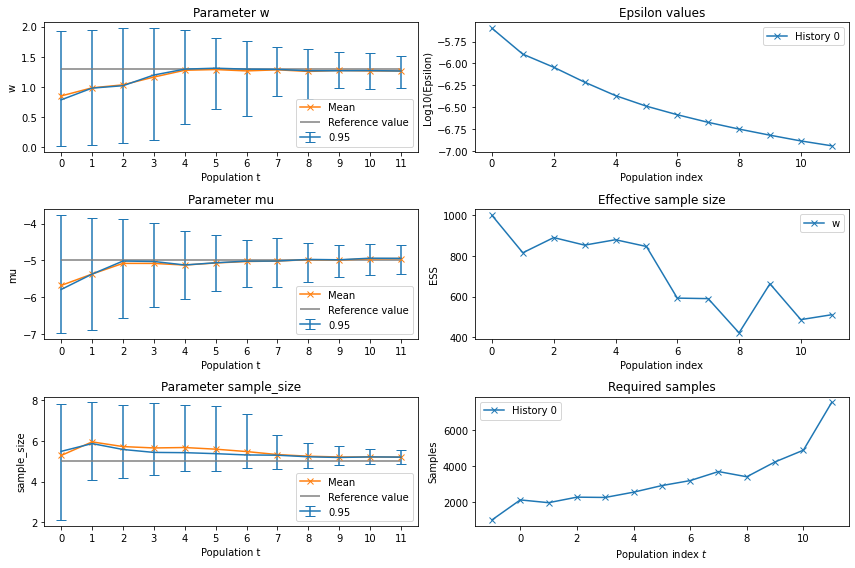

In [116]:
compare_methods(-5, 1.3, 5, 0.00000001, data_size=5, max_episodes=12) # new dist

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=304, start_time=2021-03-10 12:48:36.639725, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring from avgs
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 2.796862857878584e-06
INFO:ABC:t: 0, eps: 2.796862857878584e-06.
INFO:ABC:Acceptance rate: 1000 / 2046 = 4.8876e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 1.5491260789990678e-06.
INFO:ABC:Acceptance rate: 1000 / 2045 = 4.8900e-01, ESS=8.5013e+02.
INFO:ABC:t: 2, eps: 1.3206337134981434e-06.
INFO:ABC:Acceptance rate: 1000 / 2461 = 4.0634e-01, ESS=8.0641e+02.
INFO:ABC:t: 3, eps: 1.0070875593032415e-06.
INFO:ABC:Acceptance rate: 1000 / 2191 = 4.5641e-01, ESS=8.3349e+02.
INFO:ABC:t: 4, eps: 7.584218286859753e-07.
INFO:ABC:Acceptance rate: 1000 / 2313 = 4.3234e-01, ESS=8.4802e+02.
INFO:ABC:t: 5, eps: 5.611540019593772e-07.
INFO:ABC:Acceptance rate: 1000 / 2308 = 4.3328e-01, ESS=8.7732e+02.
INFO:ABC:t: 6, eps: 4.24259985302038e-07.
INFO:ABC:Acceptance rate: 1000 / 2292 = 4.3630e-01, ESS=9.0099e+02.
INFO:ABC:t: 7, eps: 3.250752372434295e-07.
INFO:ABC:Acceptance rate: 1000 / 2141 = 4.6707e-01, ESS=9.0186e+02.
INFO:ABC:t: 8, eps: 2.572932952164842e-07.
INFO:ABC:Acce

SMC run time:  59.57
Total number of SMC simulations:  23394


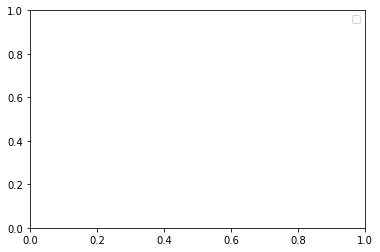

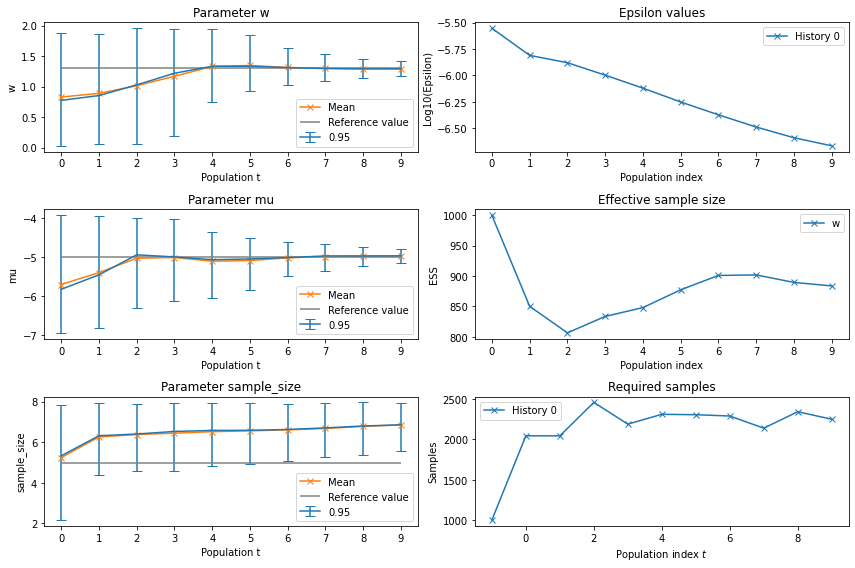

In [89]:
compare_methods(-5, 1.3, 5, 0.00000001, data_size=5) 

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=307, start_time=2021-03-10 12:53:24.993018, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring from avgs
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 1.5694572167537604e-06
INFO:ABC:t: 0, eps: 1.5694572167537604e-06.
INFO:ABC:Acceptance rate: 1000 / 1889 = 5.2938e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 7.693400876947073e-07.
INFO:ABC:Acceptance rate: 1000 / 1967 = 5.0839e-01, ESS=8.7963e+02.
INFO:ABC:t: 2, eps: 4.4189975901851506e-07.
INFO:ABC:Acceptance rate: 1000 / 2111 = 4.7371e-01, ESS=8.7087e+02.
INFO:ABC:t: 3, eps: 3.2304673843412704e-07.
INFO:ABC:Acceptance rate: 1000 / 2132 = 4.6904e-01, ESS=8.5516e+02.
INFO:ABC:t: 4, eps: 2.7390951764209596e-07.
INFO:ABC:Acceptance rate: 1000 / 2164 = 4.6211e-01, ESS=8.4394e+02.
INFO:ABC:t: 5, eps: 2.529716293011717e-07.
INFO:ABC:Acceptance rate: 1000 / 2417 = 4.1374e-01, ESS=7.3128e+02.
INFO:ABC:t: 6, eps: 2.4050182786768914e-07.
INFO:ABC:Acceptance rate: 1000 / 3158 = 3.1666e-01, ESS=6.7238e+02.
INFO:ABC:t: 7, eps: 2.3251858001006794e-07.
INFO:ABC:Acceptance rate: 1000 / 5313 = 1.8822e-01, ESS=3.5883e+02.
INFO:ABC:t: 8, eps: 2.2606410715378934e-07.
INFO:AB

SMC run time:  109.01
Total number of SMC simulations:  64925


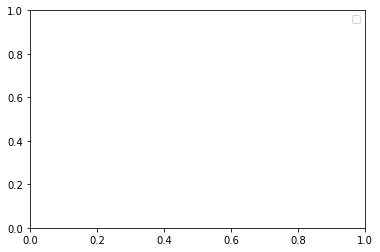

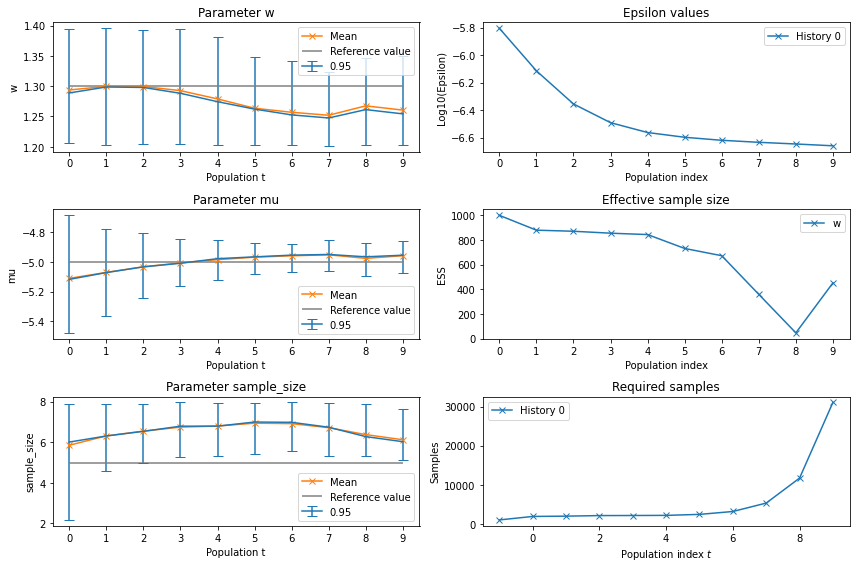

In [92]:
compare_methods(-5, 1.3, 5, 0.00000001, data_size=5, w_prior=(1.2,0.2), mu_prior=(-5.5,1)) 

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=308, start_time=2021-03-10 12:57:29.143946, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring from avgs
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.004291653918157038
INFO:ABC:t: 0, eps: 0.004291653918157038.
INFO:ABC:Acceptance rate: 1000 / 1998 = 5.0050e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.0025809062677166327.
INFO:ABC:Acceptance rate: 1000 / 1891 = 5.2882e-01, ESS=9.0832e+02.
INFO:ABC:t: 2, eps: 0.0017736675219298841.
INFO:ABC:Acceptance rate: 1000 / 2052 = 4.8733e-01, ESS=8.7051e+02.
INFO:ABC:t: 3, eps: 0.0014098721356412942.
INFO:ABC:Acceptance rate: 1000 / 1982 = 5.0454e-01, ESS=8.1908e+02.
INFO:ABC:t: 4, eps: 0.0012533923939306779.
INFO:ABC:Acceptance rate: 1000 / 2184 = 4.5788e-01, ESS=8.7764e+02.
INFO:ABC:t: 5, eps: 0.0011633427341267493.
INFO:ABC:Acceptance rate: 1000 / 2305 = 4.3384e-01, ESS=8.3044e+02.
INFO:ABC:t: 6, eps: 0.0011109435397350094.
INFO:ABC:Acceptance rate: 1000 / 2555 = 3.9139e-01, ESS=5.0864e+02.
INFO:ABC:t: 7, eps: 0.0010844435439317742.
INFO:ABC:Acceptance rate: 1000 / 3056 = 3.2723e-01, ESS=6.8894e+02.
INFO:ABC:t: 8, eps: 0.001062991231960561.
INFO:ABC:Acceptanc

SMC run time:  75.39
Total number of SMC simulations:  38338


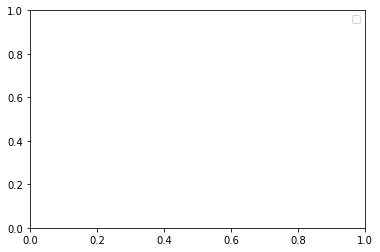

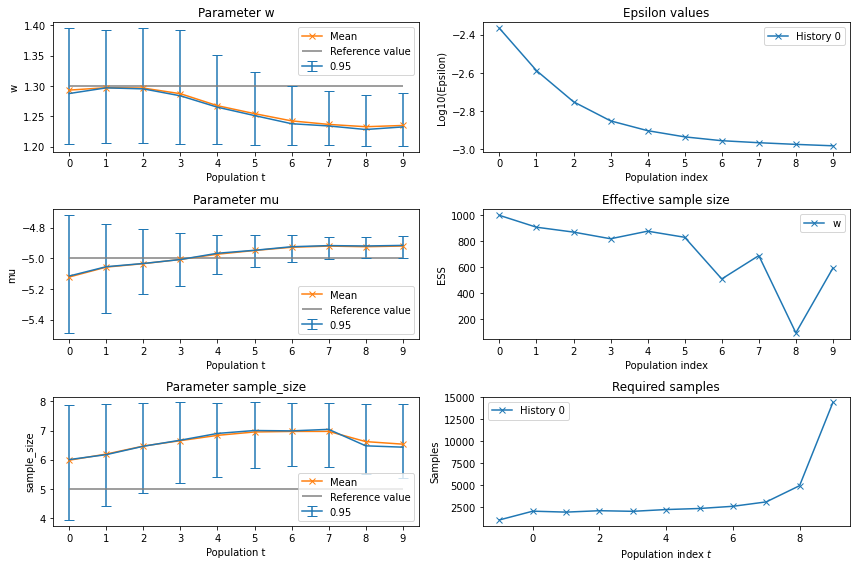

In [96]:
compare_methods(-5, 1.3, 5, 0.00000001, data_size=5, w_prior=(1.2,0.2), mu_prior=(-5.5,1)) # no std in distance

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=306, start_time=2021-03-10 12:51:26.256737, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring from avgs
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 1.2566760813886793e-05
INFO:ABC:t: 0, eps: 1.2566760813886793e-05.
INFO:ABC:Acceptance rate: 1000 / 2050 = 4.8780e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 7.384974553421139e-06.
INFO:ABC:Acceptance rate: 1000 / 2516 = 3.9746e-01, ESS=8.3333e+02.
INFO:ABC:t: 2, eps: 7.1554175279993285e-06.
INFO:ABC:Acceptance rate: 1000 / 3186 = 3.1387e-01, ESS=5.9756e+02.
INFO:ABC:t: 3, eps: 7.1554175279993285e-06.
INFO:ABC:Acceptance rate: 1000 / 1734 = 5.7670e-01, ESS=4.9903e+02.
INFO:ABC:t: 4, eps: 7.1554175279993285e-06.
INFO:ABC:Acceptance rate: 1000 / 1873 = 5.3390e-01, ESS=1.1561e+02.
INFO:ABC:t: 5, eps: 7.1554175279993285e-06.
INFO:ABC:Acceptance rate: 1000 / 2250 = 4.4444e-01, ESS=6.8712e+02.
INFO:ABC:t: 6, eps: 7.1554175279993285e-06.
INFO:ABC:Acceptance rate: 1000 / 1814 = 5.5127e-01, ESS=5.9879e+02.
INFO:ABC:t: 7, eps: 7.1554175279993285e-06.
INFO:ABC:Acceptance rate: 1000 / 1865 = 5.3619e-01, ESS=5.9120e+02.
INFO:ABC:t: 8, eps: 7.1554175279993285e-06.
INFO:A

SMC run time:  66.97
Total number of SMC simulations:  22156


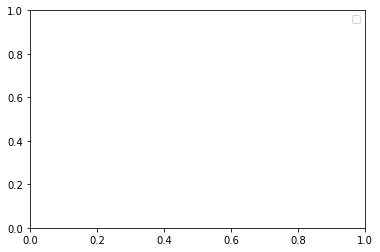

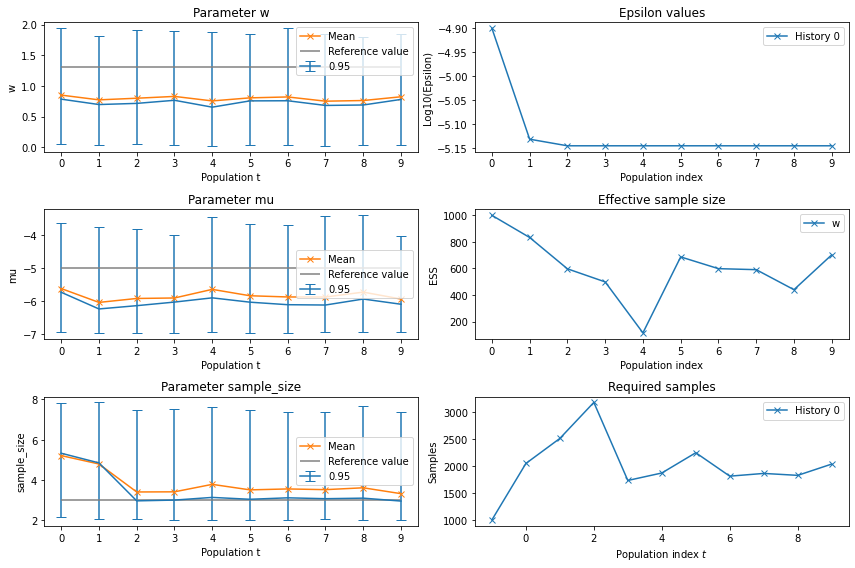

In [91]:
compare_methods(-5, 1.3, 3, 0.00000001, wt_freq=0, data_size=5) 

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=305, start_time=2021-03-10 12:49:58.570858, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Inferring from avgs
Inferring with mega distance function


INFO:Epsilon:initial epsilon is 0.20921638859909228
INFO:ABC:t: 0, eps: 0.20921638859909228.
INFO:ABC:Acceptance rate: 1000 / 1970 = 5.0761e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.1706779258240173.
INFO:ABC:Acceptance rate: 1000 / 2400 = 4.1667e-01, ESS=7.7394e+02.
INFO:ABC:t: 2, eps: 0.09931186323620557.
INFO:ABC:Acceptance rate: 1000 / 2127 = 4.7015e-01, ESS=8.6053e+02.
INFO:ABC:t: 3, eps: 0.04971358176744495.
INFO:ABC:Acceptance rate: 1000 / 2242 = 4.4603e-01, ESS=8.7553e+02.
INFO:ABC:t: 4, eps: 0.026656276179613993.
INFO:ABC:Acceptance rate: 1000 / 2096 = 4.7710e-01, ESS=8.1368e+02.
INFO:ABC:t: 5, eps: 0.013584459425635066.
INFO:ABC:Acceptance rate: 1000 / 2072 = 4.8263e-01, ESS=8.6235e+02.
INFO:ABC:t: 6, eps: 0.006701897166787808.
INFO:ABC:Acceptance rate: 1000 / 2247 = 4.4504e-01, ESS=8.5423e+02.
INFO:ABC:t: 7, eps: 0.0035075997984950766.
INFO:ABC:Acceptance rate: 1000 / 2255 = 4.4346e-01, ESS=8.4649e+02.
INFO:ABC:t: 8, eps: 0.0019725334876388085.
INFO:ABC:Acceptance rate: 100

SMC run time:  64.48
Total number of SMC simulations:  23070


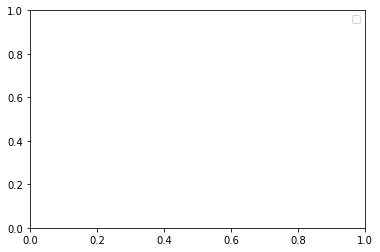

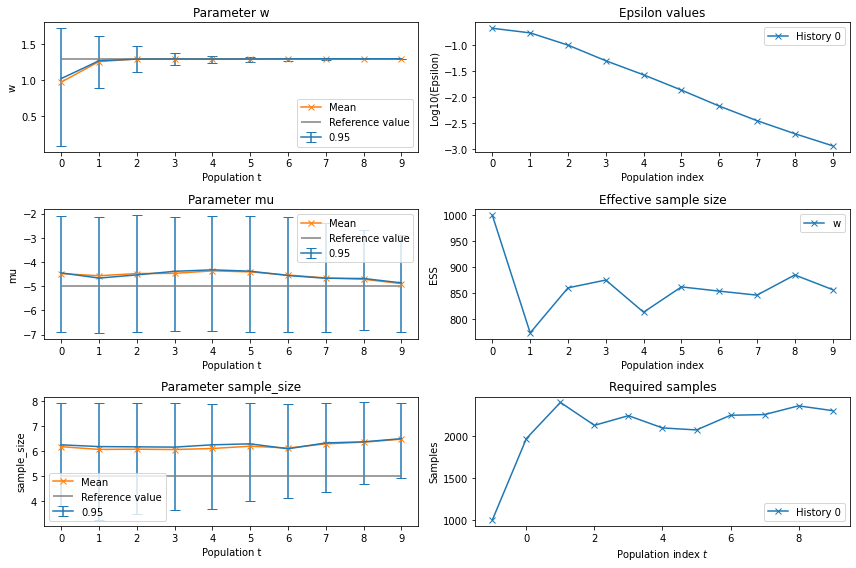

In [90]:
compare_methods(-5, 1.3, 5, 0.00000001, wt_freq=0.1, data_size=5) 

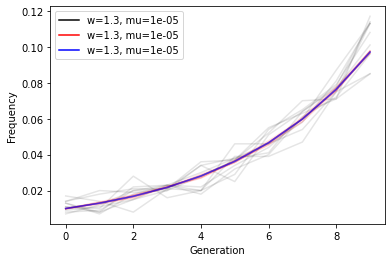

In [74]:
ss3 = simulate_data(generations_number=10, wt_freq=0.01, population_size=10**8, fitness=1.3, mutation_rate=10**-5, 
              sequence_sample_size=10**3, color='black')
ss5 = simulate_data(generations_number=10, wt_freq=0.01, population_size=10**8, fitness=1.3, mutation_rate=10**-5, 
              sequence_sample_size=10**5, color='red')
ss8 = simulate_data(generations_number=10, wt_freq=0.01, population_size=10**8, fitness=1.3, mutation_rate=10**-5, 
              sequence_sample_size=10**8, color='blue')

In [80]:
abs_diff_low = abs(ss5 - ss8)
abs_diff_high = abs(ss3 - ss8)

In [86]:
diff_sum = abs_diff_high.sum().sum()
std_sum = abs_diff_high.std().sum()
std_sum * diff_sum

0.0154394068959663

In [85]:
diff_sum = abs_diff_low.sum().sum()
std_sum = abs_diff_low.std().sum()
std_sum * diff_sum

0.00014079816704415675

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=140, start_time=2021-03-02 11:20:18.597205, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Trying to infer mutation rate -5.5 and fitness 1


INFO:Epsilon:initial epsilon is 0.002217799999999983
INFO:ABC:t: 0, eps: 0.002217799999999983.
INFO:ABC:Acceptance rate: 100 / 212 = 4.7170e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.00013559999999999985.
INFO:ABC:Acceptance rate: 100 / 198 = 5.0505e-01, ESS=7.7258e+01.
INFO:ABC:t: 2, eps: 0.00011680000000000007.
INFO:ABC:Acceptance rate: 100 / 190 = 5.2632e-01, ESS=9.0854e+01.
INFO:ABC:t: 3, eps: 9.720000000000003e-05.
INFO:ABC:Acceptance rate: 100 / 274 = 3.6496e-01, ESS=9.6165e+01.
INFO:ABC:t: 4, eps: 8.237252504554134e-05.
INFO:ABC:Acceptance rate: 100 / 375 = 2.6667e-01, ESS=8.6159e+01.
INFO:ABC:t: 5, eps: 7.240000000000008e-05.
INFO:ABC:Acceptance rate: 100 / 690 = 1.4493e-01, ESS=6.2583e+01.
INFO:ABC:t: 6, eps: 6.305455156763167e-05.
INFO:ABC:Acceptance rate: 100 / 1414 = 7.0721e-02, ESS=7.7123e+01.
INFO:ABC:t: 7, eps: 5.7599999999999984e-05.
INFO:ABC:Acceptance rate: 100 / 2127 = 4.7015e-02, ESS=8.7310e+01.
INFO:ABC:t: 8, eps: 5.2892228991580216e-05.
INFO:ABC:Acceptance rate: 1

SMC run time:  9.88
Total number of SMC simulations:  14782


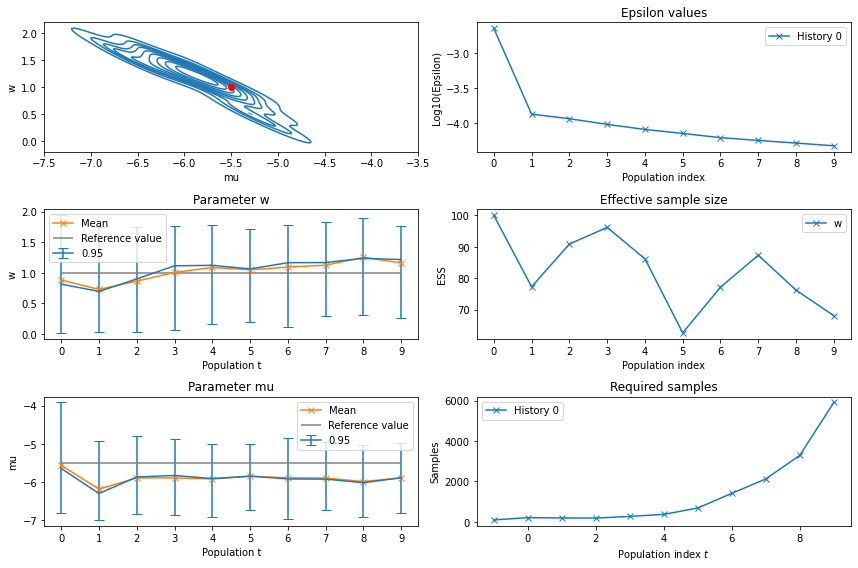

In [16]:
mr = -5.5
w = 1
post = infer(mr, w, 0.00001, smc_population_size=100)
plot_post_graphs(post, mr, w)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=139, start_time=2021-03-02 11:17:06.606073, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Trying to infer mutation rate -5.5 and fitness 1


INFO:Epsilon:initial epsilon is 0.0018556
INFO:ABC:t: 0, eps: 0.0018556.
INFO:ABC:Acceptance rate: 10000 / 19600 = 5.1020e-01, ESS=1.0000e+04.
INFO:ABC:t: 1, eps: 0.0001444000000000001.
INFO:ABC:Acceptance rate: 10000 / 16411 = 6.0935e-01, ESS=9.6461e+03.
INFO:ABC:t: 2, eps: 0.0001244000000000001.
INFO:ABC:Acceptance rate: 10000 / 19941 = 5.0148e-01, ESS=9.3357e+03.
INFO:ABC:t: 3, eps: 0.0001044000000000001.
INFO:ABC:Acceptance rate: 10000 / 24855 = 4.0233e-01, ESS=8.6841e+03.
INFO:ABC:t: 4, eps: 9.000000000000005e-05.
INFO:ABC:Acceptance rate: 10000 / 36199 = 2.7625e-01, ESS=7.0102e+03.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=139, start_time=2021-03-02 11:17:06.606073, end_time=2021-03-02 11:19:02.462934)>


SMC run time:  115.9
Total number of SMC simulations:  127006


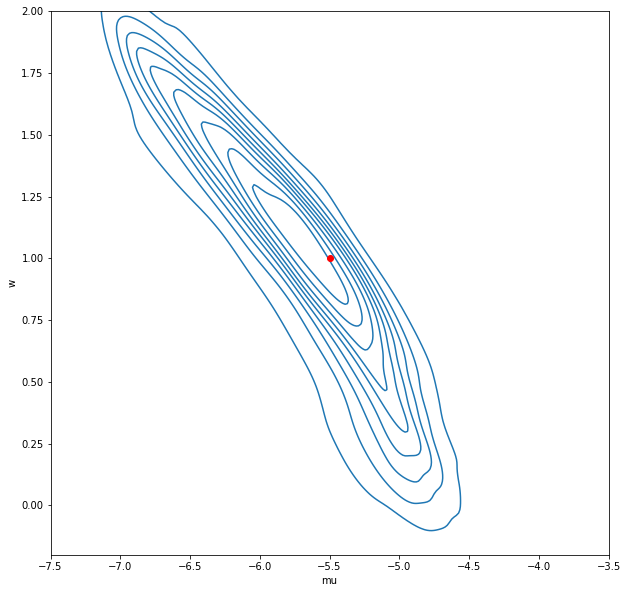

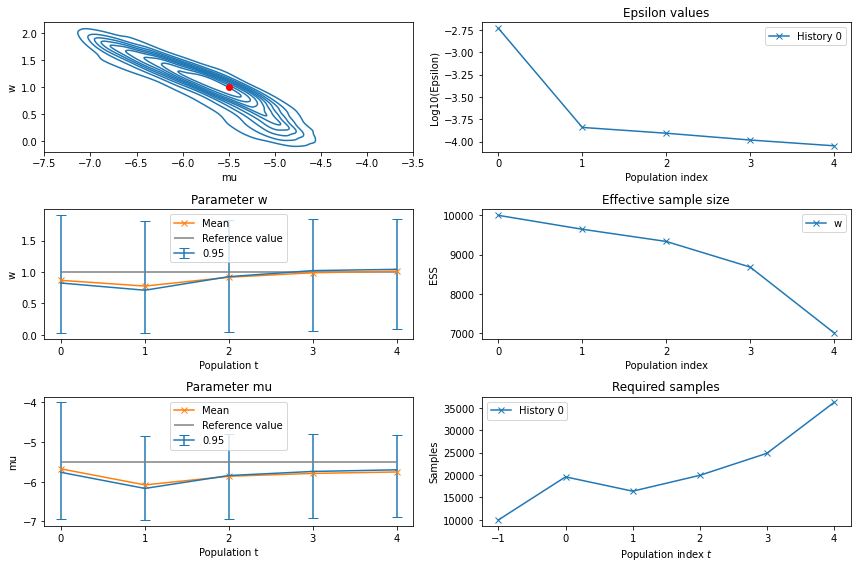

In [11]:
mr = -5.5
w = 1
post = infer(mr, w, axes, 0.0001, smc_population_size=10000)
plot_post_graphs(post, mr, w)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=155, start_time=2021-03-02 12:41:54.044062, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Trying to infer mutation rate -6 and fitness 0.8


INFO:Epsilon:initial epsilon is 0.0015255999999999963
INFO:ABC:t: 0, eps: 0.0015255999999999963.
INFO:ABC:Acceptance rate: 1000 / 2071 = 4.8286e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 7.74e-05.
INFO:ABC:Acceptance rate: 1000 / 2117 = 4.7237e-01, ESS=9.5412e+02.
INFO:ABC:t: 2, eps: 3.46e-05.
INFO:ABC:Acceptance rate: 1000 / 1944 = 5.1440e-01, ESS=9.2064e+02.
INFO:ABC:t: 3, eps: 2.9400000000000003e-05.
INFO:ABC:Acceptance rate: 1000 / 1977 = 5.0582e-01, ESS=8.6500e+02.
INFO:ABC:t: 4, eps: 2.9400000000000003e-05.
INFO:ABC:Acceptance rate: 1000 / 1785 = 5.6022e-01, ESS=7.5614e+02.
INFO:ABC:t: 5, eps: 2.9400000000000003e-05.
INFO:ABC:Acceptance rate: 1000 / 1692 = 5.9102e-01, ESS=7.0578e+02.
INFO:ABC:t: 6, eps: 2.9400000000000003e-05.
INFO:ABC:Acceptance rate: 1000 / 1781 = 5.6148e-01, ESS=4.0505e+02.
INFO:ABC:t: 7, eps: 2.9400000000000003e-05.
INFO:ABC:Acceptance rate: 1000 / 1708 = 5.8548e-01, ESS=5.6712e+02.
INFO:ABC:t: 8, eps: 2.9400000000000003e-05.
INFO:ABC:Acceptance rate: 1000 / 17

SMC run time:  22.46
Total number of SMC simulations:  19590


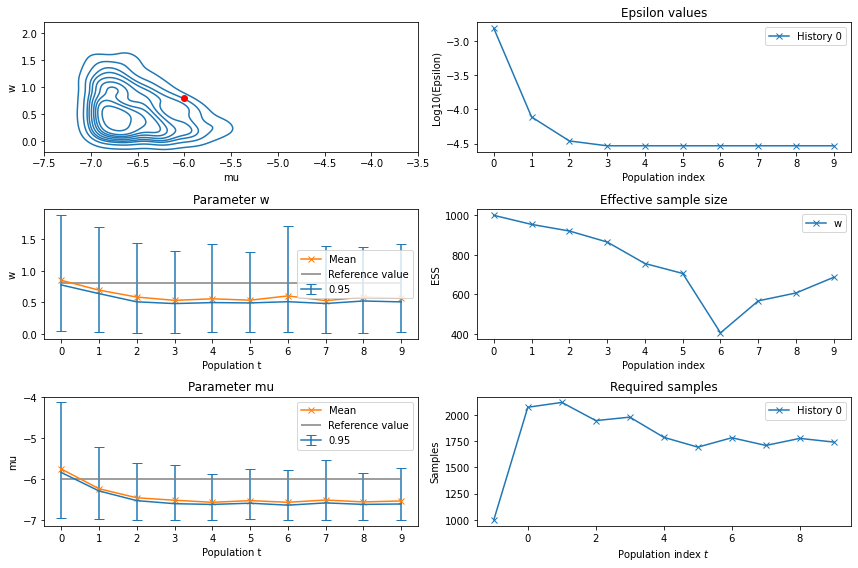

In [44]:
mr = -6
w = 0.8
post = infer(mr, w, 0.00001, smc_population_size=1000)
plot_post_graphs(post, mr, w)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=151, start_time=2021-03-02 11:38:37.270343, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Trying to infer mutation rate -5 and fitness 0.8


INFO:Epsilon:initial epsilon is 0.0012485999999999923
INFO:ABC:t: 0, eps: 0.0012485999999999923.
INFO:ABC:Acceptance rate: 100 / 217 = 4.6083e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.000254.
INFO:ABC:Acceptance rate: 100 / 215 = 4.6512e-01, ESS=8.9389e+01.
INFO:ABC:t: 2, eps: 0.00018903124235383593.
INFO:ABC:Acceptance rate: 100 / 257 = 3.8911e-01, ESS=9.1127e+01.
INFO:ABC:t: 3, eps: 0.00016495053089345807.
INFO:ABC:Acceptance rate: 100 / 301 = 3.3223e-01, ESS=9.4493e+01.
INFO:ABC:t: 4, eps: 0.00014468199440099505.
INFO:ABC:Acceptance rate: 100 / 287 = 3.4843e-01, ESS=7.4554e+01.
INFO:ABC:t: 5, eps: 0.00011940000000000007.
INFO:ABC:Acceptance rate: 100 / 551 = 1.8149e-01, ESS=8.9021e+01.
INFO:ABC:t: 6, eps: 0.00010500000000000002.
INFO:ABC:Acceptance rate: 100 / 881 = 1.1351e-01, ESS=8.7528e+01.
INFO:ABC:t: 7, eps: 9.180000000000009e-05.
INFO:ABC:Acceptance rate: 100 / 1621 = 6.1690e-02, ESS=8.1050e+01.
INFO:ABC:t: 8, eps: 8.140000000000005e-05.
INFO:ABC:Acceptance rate: 100 / 2637 =

SMC run time:  9.67
Total number of SMC simulations:  12208


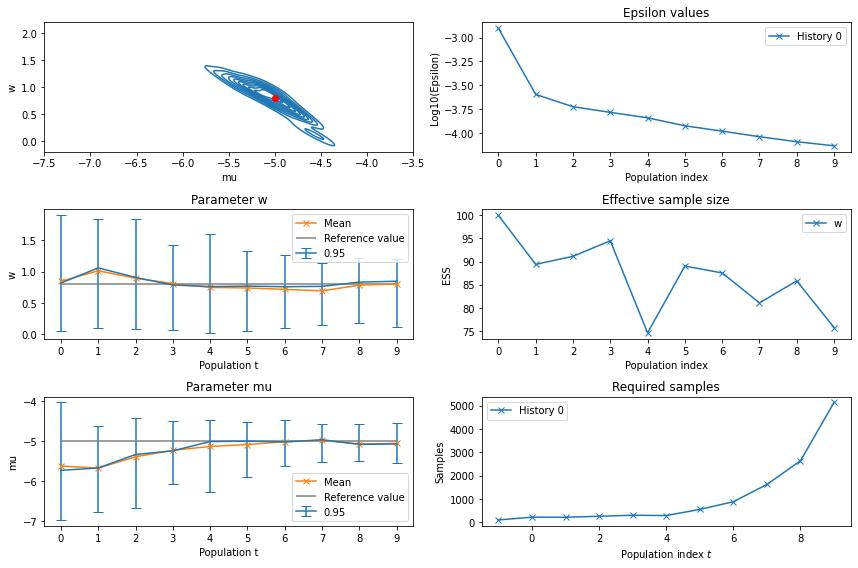

In [40]:
mr = -5
w = 0.8
post = infer(mr, w, 0.00001, smc_population_size=100)
plot_post_graphs(post, mr, w)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=153, start_time=2021-03-02 11:39:36.293437, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Trying to infer mutation rate -5 and fitness 0.8


INFO:Epsilon:initial epsilon is 0.002199799999999992
INFO:ABC:t: 0, eps: 0.002199799999999992.
INFO:ABC:Acceptance rate: 1000 / 1883 = 5.3107e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00028020000000000014.
INFO:ABC:Acceptance rate: 1000 / 1813 = 5.5157e-01, ESS=9.6002e+02.
INFO:ABC:t: 2, eps: 0.00023580000000000004.
INFO:ABC:Acceptance rate: 1000 / 2100 = 4.7619e-01, ESS=9.5593e+02.
INFO:ABC:t: 3, eps: 0.00019020000000000012.
INFO:ABC:Acceptance rate: 1000 / 2029 = 4.9285e-01, ESS=9.1210e+02.
INFO:ABC:t: 4, eps: 0.00015780000000000012.
INFO:ABC:Acceptance rate: 1000 / 2699 = 3.7051e-01, ESS=8.9577e+02.
INFO:ABC:t: 5, eps: 0.00013140000000000013.
INFO:ABC:Acceptance rate: 1000 / 3640 = 2.7473e-01, ESS=7.4236e+02.
INFO:ABC:t: 6, eps: 0.00011340000000000002.
INFO:ABC:Acceptance rate: 1000 / 6117 = 1.6348e-01, ESS=7.2218e+02.
INFO:ABC:t: 7, eps: 0.00010020000000000013.
INFO:ABC:Acceptance rate: 1000 / 10177 = 9.8261e-02, ESS=6.5481e+02.
INFO:ABC:t: 8, eps: 8.94e-05.
INFO:ABC:Acceptance ra

SMC run time:  49.16
Total number of SMC simulations:  85351


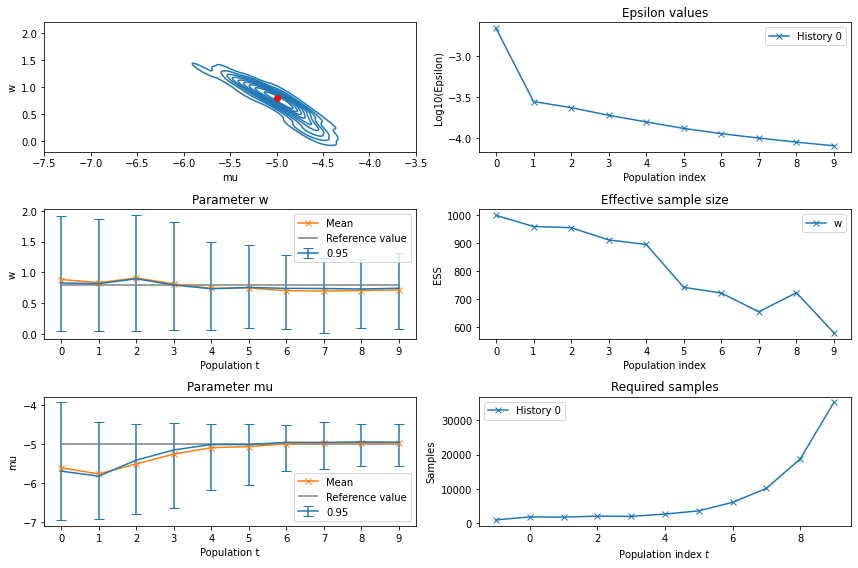

In [42]:
mr = -5
w = 0.8
post = infer(mr, w, 0.00001, smc_population_size=1000)
plot_post_graphs(post, mr, w)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=150, start_time=2021-03-02 11:32:40.743452, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Trying to infer mutation rate -6 and fitness 0.8


INFO:Epsilon:initial epsilon is 0.0017062000000000002
INFO:ABC:t: 0, eps: 0.0017062000000000002.
INFO:ABC:Acceptance rate: 10000 / 20472 = 4.8847e-01, ESS=1.0000e+04.
INFO:ABC:t: 1, eps: 9.340000000000001e-05.
INFO:ABC:Acceptance rate: 10000 / 20576 = 4.8600e-01, ESS=9.5869e+03.
INFO:ABC:t: 2, eps: 3.2200000000000003e-05.
INFO:ABC:Acceptance rate: 10000 / 20623 = 4.8490e-01, ESS=9.5882e+03.
INFO:ABC:t: 3, eps: 2.3800000000000003e-05.
INFO:ABC:Acceptance rate: 10000 / 22533 = 4.4379e-01, ESS=9.1022e+03.
INFO:ABC:t: 4, eps: 2.3800000000000003e-05.
INFO:ABC:Acceptance rate: 10000 / 17562 = 5.6941e-01, ESS=6.5136e+03.
INFO:ABC:t: 5, eps: 2.3800000000000003e-05.
INFO:ABC:Acceptance rate: 10000 / 17553 = 5.6970e-01, ESS=7.1349e+03.
INFO:History:Done <ABCSMC(id=150, start_time=2021-03-02 11:32:40.743452, end_time=2021-03-02 11:34:55.620324)>


SMC run time:  134.92
Total number of SMC simulations:  129319


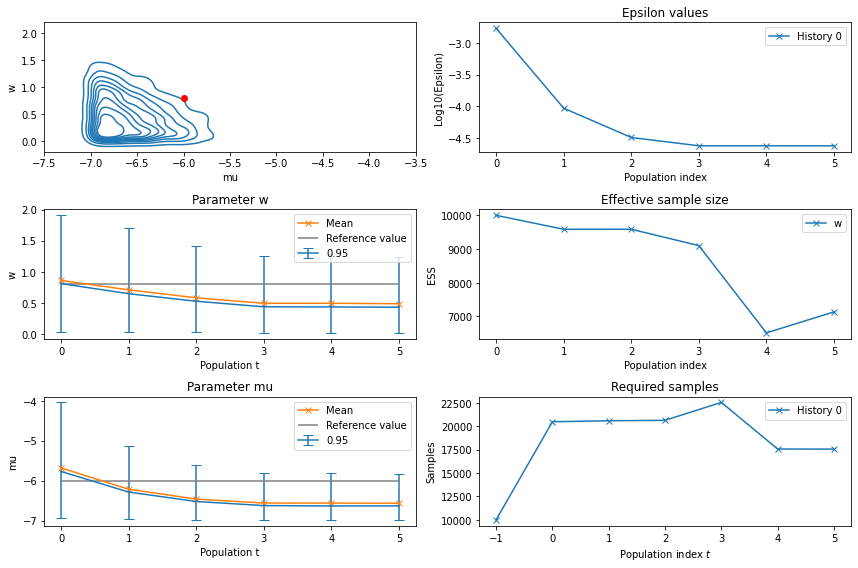

In [39]:
mr = -6
w = 0.8
post = infer(mr, w, 0.00001, smc_population_size=10000, max_episodes=6)
plot_post_graphs(post, mr, w)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=129, start_time=2021-03-02 10:51:30.404908, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Trying to infer mutation rate -6 and fitness 0.8


INFO:Epsilon:initial epsilon is 0.001856399999999996
INFO:ABC:t: 0, eps: 0.001856399999999996.
INFO:ABC:Acceptance rate: 1000 / 2005 = 4.9875e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 9.459999999999985e-05.
INFO:ABC:Acceptance rate: 1000 / 2090 = 4.7847e-01, ESS=9.3836e+02.
INFO:ABC:t: 2, eps: 3.56e-05.
INFO:ABC:Acceptance rate: 1000 / 1965 = 5.0891e-01, ESS=9.3420e+02.
INFO:ABC:t: 3, eps: 2.96e-05.
INFO:ABC:Acceptance rate: 1000 / 1877 = 5.3277e-01, ESS=8.3776e+02.
INFO:ABC:t: 4, eps: 2.96e-05.
INFO:ABC:Acceptance rate: 1000 / 1655 = 6.0423e-01, ESS=7.1501e+02.
INFO:ABC:t: 5, eps: 2.96e-05.
INFO:ABC:Acceptance rate: 1000 / 1676 = 5.9666e-01, ESS=7.6157e+02.
INFO:ABC:t: 6, eps: 2.96e-05.
INFO:ABC:Acceptance rate: 1000 / 1722 = 5.8072e-01, ESS=7.9883e+02.
INFO:ABC:t: 7, eps: 2.96e-05.
INFO:ABC:Acceptance rate: 1000 / 1677 = 5.9630e-01, ESS=5.5083e+02.
INFO:ABC:t: 8, eps: 2.96e-05.
INFO:ABC:Acceptance rate: 1000 / 1714 = 5.8343e-01, ESS=5.2665e+02.
INFO:ABC:t: 9, eps: 2.96e-05.
INFO:ABC:A

SMC run time:  20.87
Total number of SMC simulations:  18993


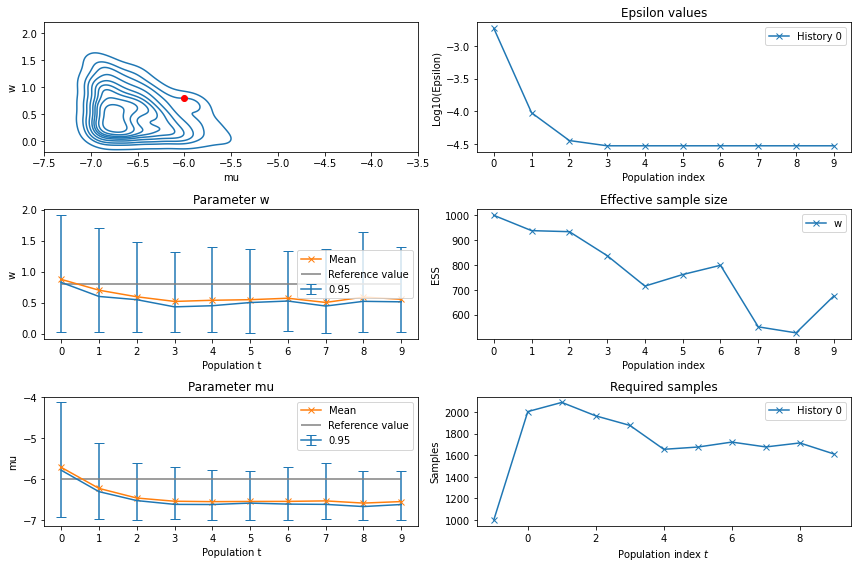

In [18]:
mr = -6
w = 0.8
post = infer(mr, w, axes, 0.00001)
plot_post_graphs(post, mr, w)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=127, start_time=2021-03-02 10:49:49.592538, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Trying to infer mutation rate -6 and fitness 0.8


INFO:Epsilon:initial epsilon is 0.0007258
INFO:ABC:t: 0, eps: 0.0007258.
INFO:ABC:Acceptance rate: 1000 / 2132 = 4.6904e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 4.9000000000000005e-05.
INFO:ABC:Acceptance rate: 1000 / 2113 = 4.7326e-01, ESS=9.2364e+02.
INFO:ABC:t: 2, eps: 2.8600000000000004e-05.
INFO:ABC:Acceptance rate: 1000 / 2078 = 4.8123e-01, ESS=9.4601e+02.
INFO:ABC:t: 3, eps: 2.4200000000000005e-05.
INFO:ABC:Acceptance rate: 1000 / 2225 = 4.4944e-01, ESS=8.8041e+02.
INFO:ABC:t: 4, eps: 2.4200000000000005e-05.
INFO:ABC:Acceptance rate: 1000 / 1875 = 5.3333e-01, ESS=6.9816e+02.
INFO:ABC:t: 5, eps: 2.4200000000000005e-05.
INFO:ABC:Acceptance rate: 1000 / 1983 = 5.0429e-01, ESS=5.0689e+01.
INFO:ABC:t: 6, eps: 2.4200000000000005e-05.
INFO:ABC:Acceptance rate: 1000 / 2381 = 4.1999e-01, ESS=8.2810e+02.
INFO:ABC:t: 7, eps: 2.4200000000000005e-05.
INFO:ABC:Acceptance rate: 1000 / 2057 = 4.8614e-01, ESS=6.2262e+02.
INFO:ABC:t: 8, eps: 2.4200000000000005e-05.
INFO:ABC:Acceptance rate: 1000 

SMC run time:  21.75
Total number of SMC simulations:  21713


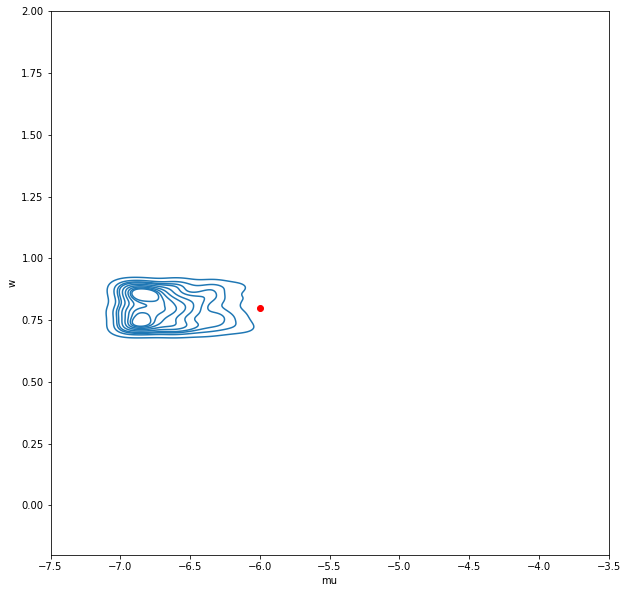

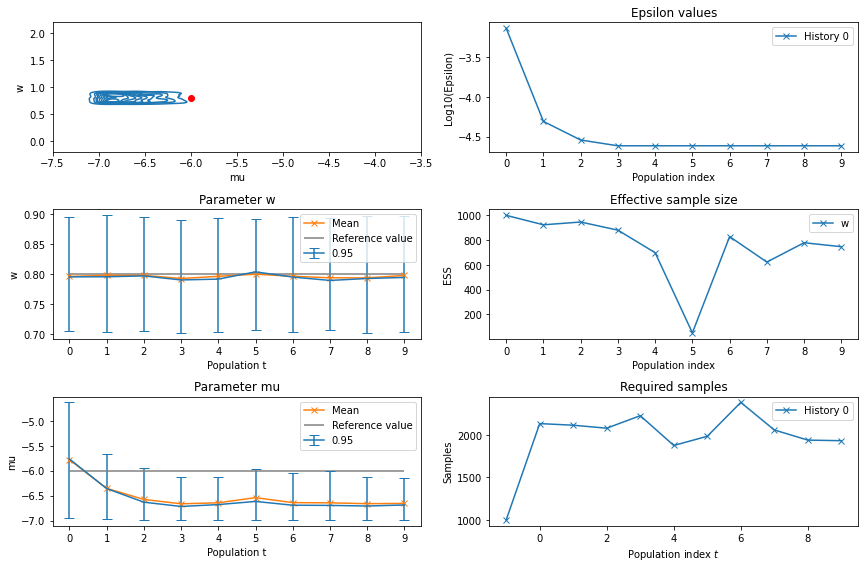

In [16]:
mr = -6
w = 0.8
post = infer(mr, w, axes, 0.00001, w_prior=(0.7, 0.2))
plot_post_graphs(post, mr, w)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=131, start_time=2021-03-02 10:53:10.718284, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Trying to infer mutation rate -6 and fitness 0.8


INFO:Epsilon:initial epsilon is 0.00016679999999999958
INFO:ABC:t: 0, eps: 0.00016679999999999958.
INFO:ABC:Acceptance rate: 1000 / 2088 = 4.7893e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 4.8799999999999865e-05.
INFO:ABC:Acceptance rate: 1000 / 2137 = 4.6795e-01, ESS=9.4177e+02.
INFO:ABC:t: 2, eps: 3.54e-05.
INFO:ABC:Acceptance rate: 1000 / 2110 = 4.7393e-01, ESS=9.2857e+02.
INFO:ABC:t: 3, eps: 3.06e-05.
INFO:ABC:Acceptance rate: 1000 / 2572 = 3.8880e-01, ESS=7.3887e+02.
INFO:ABC:t: 4, eps: 3.06e-05.
INFO:ABC:Acceptance rate: 1000 / 2320 = 4.3103e-01, ESS=3.0831e+02.
INFO:ABC:t: 5, eps: 3.06e-05.
INFO:ABC:Acceptance rate: 1000 / 2464 = 4.0584e-01, ESS=6.5145e+02.
INFO:ABC:t: 6, eps: 3.06e-05.
INFO:ABC:Acceptance rate: 1000 / 2323 = 4.3048e-01, ESS=7.4239e+02.
INFO:ABC:t: 7, eps: 3.06e-05.
INFO:ABC:Acceptance rate: 1000 / 2303 = 4.3422e-01, ESS=8.0512e+02.
INFO:ABC:t: 8, eps: 3.06e-05.
INFO:ABC:Acceptance rate: 1000 / 2252 = 4.4405e-01, ESS=4.7212e+02.
INFO:ABC:t: 9, eps: 3.06e-05.
INFO:

SMC run time:  23.8
Total number of SMC simulations:  23981


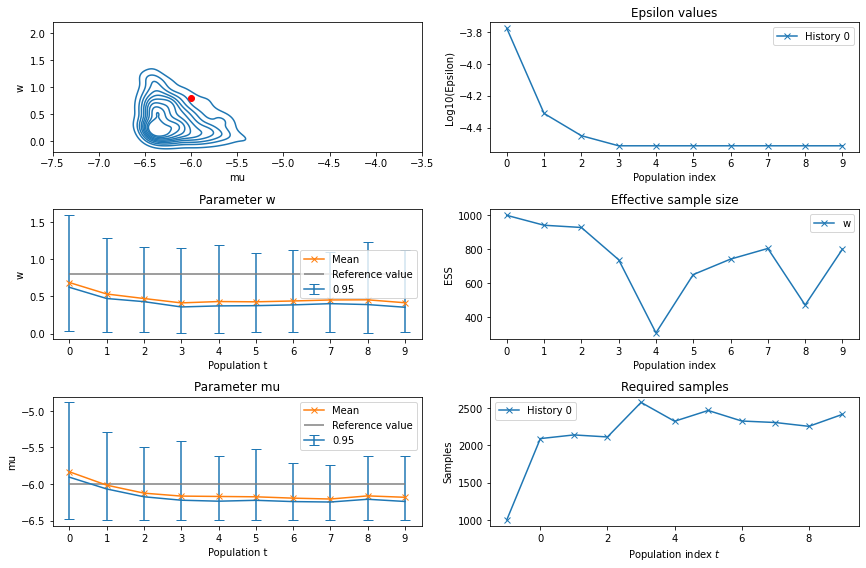

In [20]:
mr = -6
w = 0.8
post = infer(mr, w, axes, 0.00001, mu_prior=(-6.5, 2))
plot_post_graphs(post, mr, w)

NameError: name 'post' is not defined

In [25]:
df, weights = post.get_distribution(m=0)

In [57]:
def plot_2d_kde(post, ax, real_w, real_mu):
    df, weights = post.get_distribution()
    df['weights'] = weights
    sns.kdeplot(data=df, x='mu', y='w', weights='weights', ax=ax)
    ax.plot(real_mu, real_w, marker='o', color='red')
    ax.set_ylim([-0.2,2])
    ax.set_xlim([-7.5, -3.5])

In [75]:
2.72**-5.9

0.002729250925181107

<AxesSubplot:title={'center':'Epsilon values'}, xlabel='Population index', ylabel='Log10(Epsilon)'>

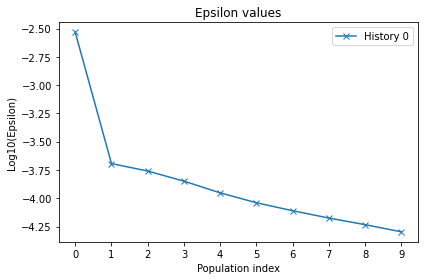

In [76]:
pyabc.visualization.plot_epsilons(post, scale='log10')

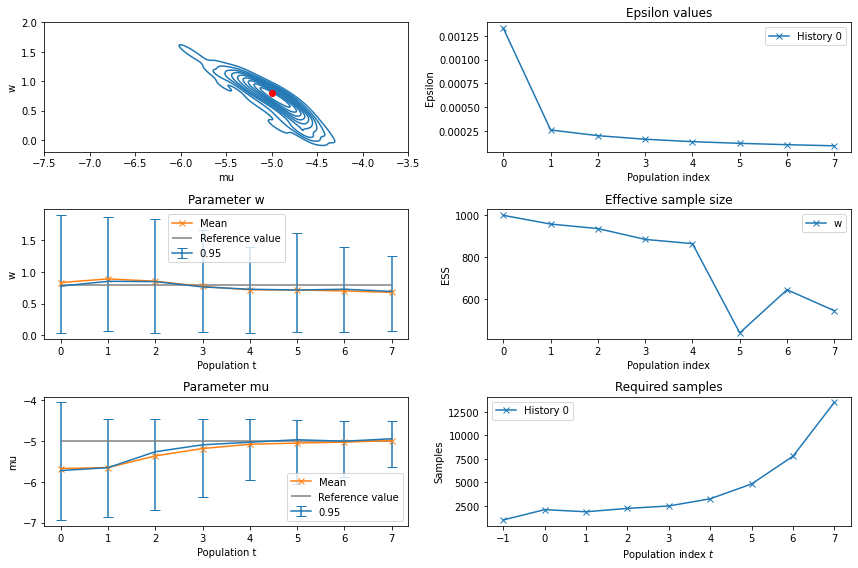

In [63]:
plot_post_graphs(post, 0.8, -5)

In [66]:
post = infer(-6, 1.5, axes, 0.00001)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=115, start_time=2021-02-25 13:33:35.941129, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Trying to infer mutation rate -6 and fitness 1.5


INFO:Epsilon:initial epsilon is 0.0029273999999999967
INFO:ABC:t: 0, eps: 0.0029273999999999967.
INFO:ABC:Acceptance rate: 1000 / 1866 = 5.3591e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.0002024000000000001.
INFO:ABC:Acceptance rate: 1000 / 2167 = 4.6147e-01, ESS=9.5056e+02.
INFO:ABC:t: 2, eps: 0.0001740000000000001.
INFO:ABC:Acceptance rate: 1000 / 2223 = 4.4984e-01, ESS=9.3439e+02.
INFO:ABC:t: 3, eps: 0.0001416000000000001.
INFO:ABC:Acceptance rate: 1000 / 2484 = 4.0258e-01, ESS=8.8359e+02.
INFO:ABC:t: 4, eps: 0.00011159999999999996.
INFO:ABC:Acceptance rate: 1000 / 2906 = 3.4412e-01, ESS=8.2060e+02.
INFO:ABC:t: 5, eps: 9.120000000000006e-05.
INFO:ABC:Acceptance rate: 1000 / 3768 = 2.6539e-01, ESS=6.9037e+02.
INFO:ABC:t: 6, eps: 7.760000000000012e-05.
INFO:ABC:Acceptance rate: 1000 / 6287 = 1.5906e-01, ESS=7.5953e+02.
INFO:ABC:t: 7, eps: 6.680000000000009e-05.
INFO:ABC:Acceptance rate: 1000 / 10967 = 9.1183e-02, ESS=7.4653e+02.
INFO:ABC:t: 8, eps: 5.8399999999999997e-05.
INFO:ABC:Acc

SMC run time:  51.02
Total number of SMC simulations:  97802


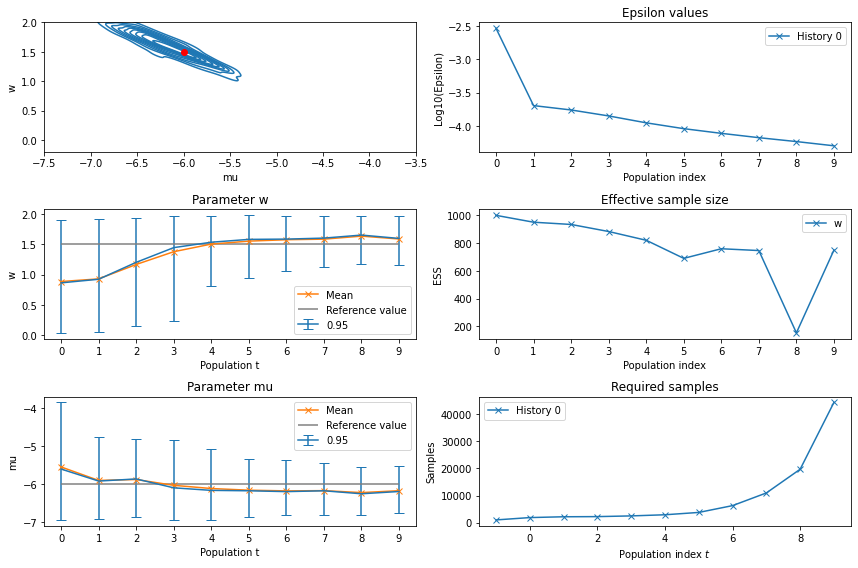

In [78]:
plot_post_graphs(post, 1.5, -6)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=118, start_time=2021-02-25 13:52:04.570685, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Trying to infer mutation rate -6 and fitness 0.5


INFO:Epsilon:initial epsilon is 0.0022047999999999916
INFO:ABC:t: 0, eps: 0.0022047999999999916.
INFO:ABC:Acceptance rate: 1000 / 1914 = 5.2247e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00012999999999999988.
INFO:ABC:Acceptance rate: 1000 / 2056 = 4.8638e-01, ESS=9.4713e+02.
INFO:ABC:t: 2, eps: 3.0200000000000002e-05.
INFO:ABC:Acceptance rate: 1000 / 2090 = 4.7847e-01, ESS=9.3937e+02.
INFO:ABC:t: 3, eps: 1.6600000000000004e-05.
INFO:ABC:Acceptance rate: 1000 / 2411 = 4.1477e-01, ESS=8.8433e+02.
INFO:ABC:t: 4, eps: 1.6600000000000004e-05.
INFO:ABC:Acceptance rate: 1000 / 1875 = 5.3333e-01, ESS=7.9002e+02.
INFO:ABC:t: 5, eps: 1.6600000000000004e-05.
INFO:ABC:Acceptance rate: 1000 / 1766 = 5.6625e-01, ESS=6.6223e+02.
INFO:ABC:t: 6, eps: 1.6600000000000004e-05.
INFO:ABC:Acceptance rate: 1000 / 1851 = 5.4025e-01, ESS=5.2595e+02.
INFO:ABC:t: 7, eps: 1.6600000000000004e-05.
INFO:ABC:Acceptance rate: 1000 / 1757 = 5.6915e-01, ESS=5.9910e+02.
INFO:ABC:t: 8, eps: 1.6600000000000004e-05.
INFO:AB

SMC run time:  22.27
Total number of SMC simulations:  20420


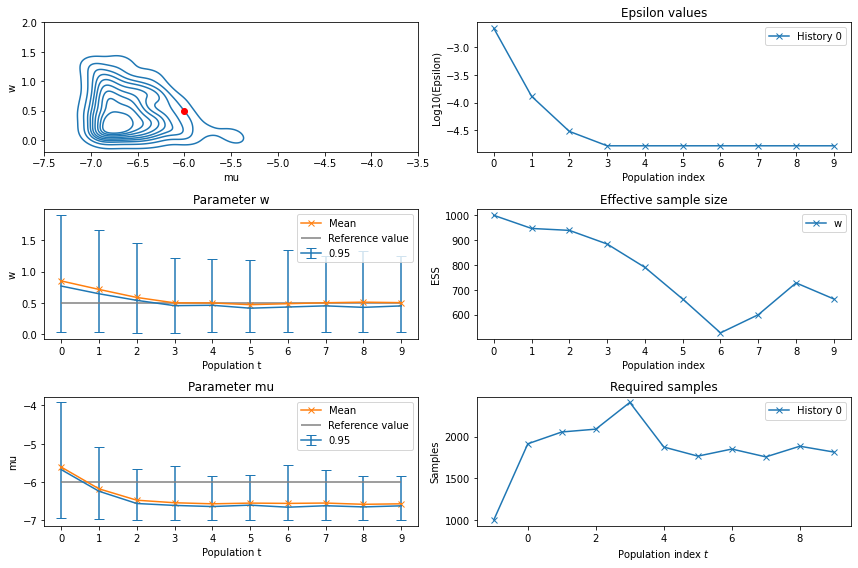

In [81]:
post = infer(-6, 0.5, axes, 0.000001)
plot_post_graphs(post, 0.5, -6)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=120, start_time=2021-02-25 13:57:11.771686, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Trying to infer mutation rate -6 and fitness 1.2


INFO:Epsilon:initial epsilon is 0.0013951999999999962
INFO:ABC:t: 0, eps: 0.0013951999999999962.
INFO:ABC:Acceptance rate: 1000 / 2184 = 4.5788e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 8.620000000000004e-05.
INFO:ABC:Acceptance rate: 1000 / 2113 = 4.7326e-01, ESS=9.5863e+02.
INFO:ABC:t: 2, eps: 7.339999999999998e-05.
INFO:ABC:Acceptance rate: 1000 / 2191 = 4.5641e-01, ESS=9.0457e+02.
INFO:ABC:t: 3, eps: 6.340000000000001e-05.
INFO:ABC:Acceptance rate: 1000 / 3146 = 3.1786e-01, ESS=8.1197e+02.
INFO:ABC:t: 4, eps: 5.460000000000004e-05.
INFO:ABC:Acceptance rate: 1000 / 4480 = 2.2321e-01, ESS=7.8822e+02.
INFO:ABC:t: 5, eps: 4.900000000000001e-05.
INFO:ABC:Acceptance rate: 1000 / 6638 = 1.5065e-01, ESS=6.7112e+02.
INFO:ABC:t: 6, eps: 4.340000000000002e-05.
INFO:ABC:Acceptance rate: 1000 / 11071 = 9.0326e-02, ESS=3.8171e+02.
INFO:ABC:t: 7, eps: 3.900000000000004e-05.
INFO:ABC:Acceptance rate: 1000 / 18107 = 5.5227e-02, ESS=6.7262e+02.
INFO:ABC:t: 8, eps: 3.460000000000004e-05.
INFO:ABC:Acce

SMC run time:  68.16
Total number of SMC simulations:  145701


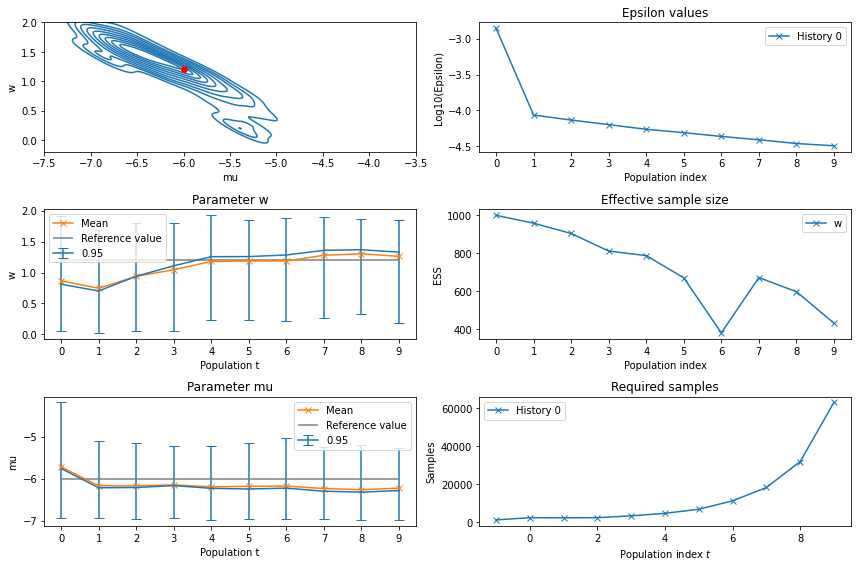

In [84]:
post = infer(-6, 1.2, axes, 0.000001)
plot_post_graphs(post,-6, 1.2)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=121, start_time=2021-02-25 13:59:01.196841, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Trying to infer mutation rate -5 and fitness 0.7


INFO:Epsilon:initial epsilon is 0.0022906
INFO:ABC:t: 0, eps: 0.0022906.
INFO:ABC:Acceptance rate: 1000 / 1920 = 5.2083e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00020940000000000016.
INFO:ABC:Acceptance rate: 1000 / 1823 = 5.4855e-01, ESS=9.5293e+02.
INFO:ABC:t: 2, eps: 0.00016940000000000016.
INFO:ABC:Acceptance rate: 1000 / 2239 = 4.4663e-01, ESS=9.4518e+02.
INFO:ABC:t: 3, eps: 0.00014020000000000005.
INFO:ABC:Acceptance rate: 1000 / 2456 = 4.0717e-01, ESS=8.8705e+02.
INFO:ABC:t: 4, eps: 0.00012019999999999993.
INFO:ABC:Acceptance rate: 1000 / 3022 = 3.3091e-01, ESS=6.7177e+02.
INFO:ABC:t: 5, eps: 0.00010340000000000005.
INFO:ABC:Acceptance rate: 1000 / 5170 = 1.9342e-01, ESS=7.9643e+02.
INFO:ABC:t: 6, eps: 9.140000000000004e-05.
INFO:ABC:Acceptance rate: 1000 / 7656 = 1.3062e-01, ESS=5.6357e+02.
INFO:ABC:t: 7, eps: 8.180000000000002e-05.
INFO:ABC:Acceptance rate: 1000 / 14444 = 6.9233e-02, ESS=7.9155e+02.
INFO:ABC:t: 8, eps: 7.380000000000002e-05.
INFO:ABC:Acceptance rate: 1000 / 

SMC run time:  54.35
Total number of SMC simulations:  105466


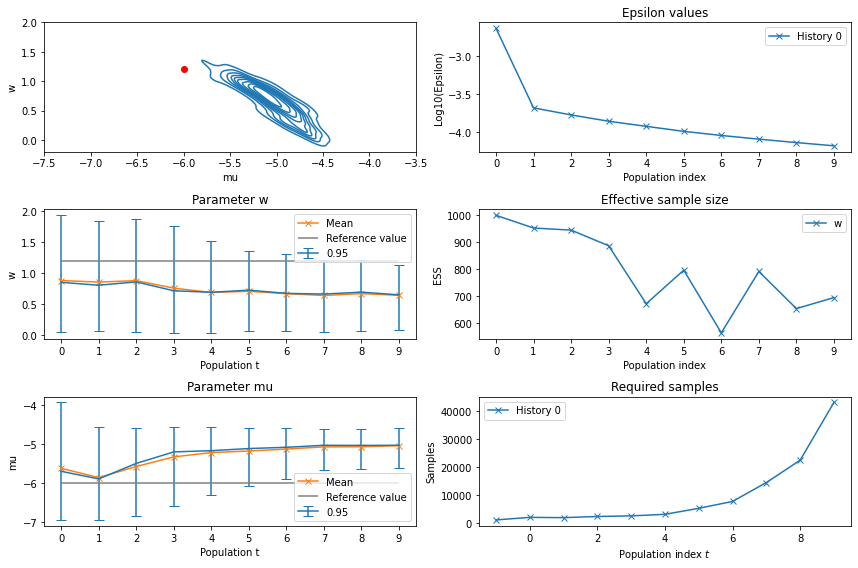

In [85]:
post = infer(-5, 0.7, axes, 0.00001)


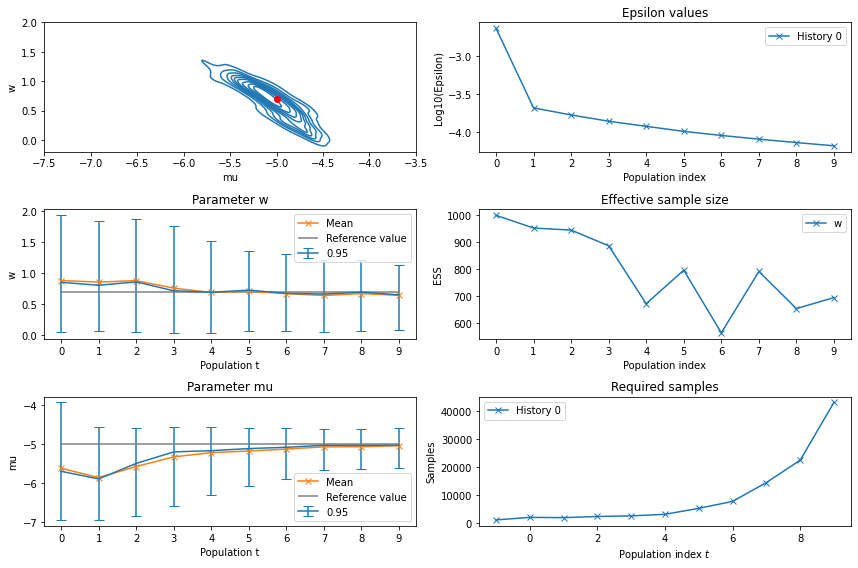

In [86]:
plot_post_graphs(post,-5, 0.7)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=104, start_time=2021-02-15 14:04:49.750690, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Trying to infer mutation rate -6 and fitness 1.5


INFO:Epsilon:initial epsilon is 0.001259399999999989
INFO:ABC:t: 0, eps: 0.001259399999999989.
INFO:ABC:Acceptance rate: 1000 / 2095 = 4.7733e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.0001956000000000001.
INFO:ABC:Acceptance rate: 1000 / 1883 = 5.3107e-01, ESS=9.5672e+02.
INFO:ABC:t: 2, eps: 0.0001656000000000001.
INFO:ABC:Acceptance rate: 1000 / 2257 = 4.4307e-01, ESS=9.1416e+02.
INFO:ABC:t: 3, eps: 0.0001356000000000001.
INFO:ABC:Acceptance rate: 1000 / 2506 = 3.9904e-01, ESS=9.0519e+02.
INFO:ABC:t: 4, eps: 0.00010912263855524735.
INFO:ABC:Acceptance rate: 1000 / 2872 = 3.4819e-01, ESS=5.7111e+02.
INFO:ABC:t: 5, eps: 9.159999999999999e-05.
INFO:ABC:Acceptance rate: 1000 / 3991 = 2.5056e-01, ESS=8.1591e+02.
INFO:ABC:t: 6, eps: 7.680000000000005e-05.
INFO:ABC:Acceptance rate: 1000 / 6398 = 1.5630e-01, ESS=5.9817e+02.
INFO:ABC:t: 7, eps: 6.640000000000003e-05.
INFO:ABC:Acceptance rate: 1000 / 11485 = 8.7070e-02, ESS=2.3493e+02.
INFO:ABC:t: 8, eps: 5.8000000000000055e-05.
INFO:ABC:Accep

SMC run time:  49.62
Total number of SMC simulations:  100656


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=105, start_time=2021-02-15 14:05:40.248113, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Trying to infer mutation rate -6 and fitness 1


INFO:Epsilon:initial epsilon is 0.0013721999999999916
INFO:ABC:t: 0, eps: 0.0013721999999999916.
INFO:ABC:Acceptance rate: 1000 / 2089 = 4.7870e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 7.500000000000001e-05.
INFO:ABC:Acceptance rate: 1000 / 2073 = 4.8239e-01, ESS=9.6154e+02.
INFO:ABC:t: 2, eps: 3.940000000000001e-05.
INFO:ABC:Acceptance rate: 1000 / 2093 = 4.7778e-01, ESS=9.3391e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=105, start_time=2021-02-15 14:05:40.248113, end_time=2021-02-15 14:05:47.553099)>


SMC run time:  7.33
Total number of SMC simulations:  7255


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=106, start_time=2021-02-15 14:05:48.449717, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Trying to infer mutation rate -6 and fitness 0.5


INFO:Epsilon:initial epsilon is 0.0018061999999999965
INFO:ABC:t: 0, eps: 0.0018061999999999965.
INFO:ABC:Acceptance rate: 1000 / 2011 = 4.9727e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00010400000000000001.
INFO:ABC:Acceptance rate: 1000 / 2026 = 4.9358e-01, ESS=9.4740e+02.
INFO:ABC:t: 2, eps: 3.24e-05.
INFO:ABC:Acceptance rate: 1000 / 1926 = 5.1921e-01, ESS=9.1514e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=106, start_time=2021-02-15 14:05:48.449717, end_time=2021-02-15 14:05:55.783960)>


SMC run time:  7.36
Total number of SMC simulations:  6964


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=107, start_time=2021-02-15 14:05:56.671938, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Trying to infer mutation rate -5 and fitness 1.5


INFO:Epsilon:initial epsilon is 0.0020530000000000006
INFO:ABC:t: 0, eps: 0.0020530000000000006.
INFO:ABC:Acceptance rate: 1000 / 1815 = 5.5096e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.0019241999999999996.
INFO:ABC:Acceptance rate: 1000 / 2090 = 4.7847e-01, ESS=9.4483e+02.
INFO:ABC:t: 2, eps: 0.0016175868866358898.
INFO:ABC:Acceptance rate: 1000 / 2051 = 4.8757e-01, ESS=9.5938e+02.
INFO:ABC:t: 3, eps: 0.0013082000000000002.
INFO:ABC:Acceptance rate: 1000 / 2012 = 4.9702e-01, ESS=9.5329e+02.
INFO:ABC:t: 4, eps: 0.0009262677755981827.
INFO:ABC:Acceptance rate: 1000 / 2115 = 4.7281e-01, ESS=9.6680e+02.
INFO:ABC:t: 5, eps: 0.0006478199631804047.
INFO:ABC:Acceptance rate: 1000 / 2060 = 4.8544e-01, ESS=9.6346e+02.
INFO:ABC:t: 6, eps: 0.00048780000000000015.
INFO:ABC:Acceptance rate: 1000 / 2445 = 4.0900e-01, ESS=9.3256e+02.
INFO:ABC:t: 7, eps: 0.00038540000000000004.
INFO:ABC:Acceptance rate: 1000 / 2764 = 3.6179e-01, ESS=8.0882e+02.
INFO:ABC:t: 8, eps: 0.00031460000000000017.
INFO:ABC:Acc

SMC run time:  27.06
Total number of SMC simulations:  28062


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=108, start_time=2021-02-15 14:06:24.688215, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Trying to infer mutation rate -5 and fitness 1


INFO:Epsilon:initial epsilon is 0.0012403999999999942
INFO:ABC:t: 0, eps: 0.0012403999999999942.
INFO:ABC:Acceptance rate: 1000 / 1984 = 5.0403e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.0004174000000000002.
INFO:ABC:Acceptance rate: 1000 / 1955 = 5.1151e-01, ESS=9.5341e+02.
INFO:ABC:t: 2, eps: 0.00031844049187718294.
INFO:ABC:Acceptance rate: 1000 / 2132 = 4.6904e-01, ESS=9.4296e+02.
INFO:ABC:t: 3, eps: 0.0002506.
INFO:ABC:Acceptance rate: 1000 / 2331 = 4.2900e-01, ESS=9.2220e+02.
INFO:ABC:t: 4, eps: 0.00020380000000000002.
INFO:ABC:Acceptance rate: 1000 / 2927 = 3.4165e-01, ESS=8.3553e+02.
INFO:ABC:t: 5, eps: 0.00017456835933620733.
INFO:ABC:Acceptance rate: 1000 / 3619 = 2.7632e-01, ESS=7.2072e+02.
INFO:ABC:t: 6, eps: 0.00014880772946887833.
INFO:ABC:Acceptance rate: 1000 / 5671 = 1.7634e-01, ESS=2.1374e+02.
INFO:ABC:t: 7, eps: 0.00013100000000000012.
INFO:ABC:Acceptance rate: 1000 / 9635 = 1.0379e-01, ESS=6.3339e+02.
INFO:ABC:t: 8, eps: 0.00011659999999999997.
INFO:ABC:Acceptance r

SMC run time:  42.02
Total number of SMC simulations:  66516


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=109, start_time=2021-02-15 14:07:07.688829, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Trying to infer mutation rate -5 and fitness 0.5


INFO:Epsilon:initial epsilon is 0.0014421999999999998
INFO:ABC:t: 0, eps: 0.0014421999999999998.
INFO:ABC:Acceptance rate: 1000 / 2002 = 4.9950e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.0001486000000000001.
INFO:ABC:Acceptance rate: 1000 / 1903 = 5.2549e-01, ESS=9.5708e+02.
INFO:ABC:t: 2, eps: 0.0001278000000000001.
INFO:ABC:Acceptance rate: 1000 / 2130 = 4.6948e-01, ESS=8.9928e+02.
INFO:ABC:t: 3, eps: 0.00010764248530948055.
INFO:ABC:Acceptance rate: 1000 / 2714 = 3.6846e-01, ESS=8.7673e+02.
INFO:ABC:t: 4, eps: 9.100000000000004e-05.
INFO:ABC:Acceptance rate: 1000 / 3630 = 2.7548e-01, ESS=7.7858e+02.
INFO:ABC:t: 5, eps: 7.94e-05.
INFO:ABC:Acceptance rate: 1000 / 5898 = 1.6955e-01, ESS=7.0000e+02.
INFO:ABC:t: 6, eps: 7.100000000000005e-05.
INFO:ABC:Acceptance rate: 1000 / 10059 = 9.9413e-02, ESS=6.9306e+02.
INFO:ABC:t: 7, eps: 6.379744834732784e-05.
INFO:ABC:Acceptance rate: 1000 / 16792 = 5.9552e-02, ESS=5.7652e+02.
INFO:ABC:t: 8, eps: 5.700000000000002e-05.
INFO:ABC:Acceptance rate:

SMC run time:  77.94
Total number of SMC simulations:  146633


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=110, start_time=2021-02-15 14:08:26.489393, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Trying to infer mutation rate -4 and fitness 1.5


INFO:Epsilon:initial epsilon is 0.020522600000000002
INFO:ABC:t: 0, eps: 0.020522600000000002.
INFO:ABC:Acceptance rate: 1000 / 2077 = 4.8146e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.0187506.
INFO:ABC:Acceptance rate: 1000 / 2094 = 4.7755e-01, ESS=9.4780e+02.
INFO:ABC:t: 2, eps: 0.015747266725319207.
INFO:ABC:Acceptance rate: 1000 / 2027 = 4.9334e-01, ESS=9.5810e+02.
INFO:ABC:t: 3, eps: 0.012035419070457102.
INFO:ABC:Acceptance rate: 1000 / 2140 = 4.6729e-01, ESS=9.6414e+02.
INFO:ABC:t: 4, eps: 0.008102600000000001.
INFO:ABC:Acceptance rate: 1000 / 2088 = 4.7893e-01, ESS=9.6644e+02.
INFO:ABC:t: 5, eps: 0.00567245896425237.
INFO:ABC:Acceptance rate: 1000 / 1926 = 5.1921e-01, ESS=9.8592e+02.
INFO:ABC:t: 6, eps: 0.004163293406810489.
INFO:ABC:Acceptance rate: 1000 / 1983 = 5.0429e-01, ESS=9.8905e+02.
INFO:ABC:t: 7, eps: 0.002992404561050938.
INFO:ABC:Acceptance rate: 1000 / 2105 = 4.7506e-01, ESS=9.8624e+02.
INFO:ABC:t: 8, eps: 0.0022175053259189544.
INFO:ABC:Acceptance rate: 1000 / 222

SMC run time:  24.22
Total number of SMC simulations:  21859


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=111, start_time=2021-02-15 14:08:51.606181, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Trying to infer mutation rate -4 and fitness 1


INFO:Epsilon:initial epsilon is 0.0044846
INFO:ABC:t: 0, eps: 0.0044846.
INFO:ABC:Acceptance rate: 1000 / 1736 = 5.7604e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.0041345999999999996.
INFO:ABC:Acceptance rate: 1000 / 2132 = 4.6904e-01, ESS=9.4076e+02.
INFO:ABC:t: 2, eps: 0.0030445999999999997.
INFO:ABC:Acceptance rate: 1000 / 2140 = 4.6729e-01, ESS=9.5707e+02.
INFO:ABC:t: 3, eps: 0.0022247091008449267.
INFO:ABC:Acceptance rate: 1000 / 2175 = 4.5977e-01, ESS=9.6207e+02.
INFO:ABC:t: 4, eps: 0.0017338239363653316.
INFO:ABC:Acceptance rate: 1000 / 2138 = 4.6773e-01, ESS=9.7372e+02.
INFO:ABC:t: 5, eps: 0.0013234.
INFO:ABC:Acceptance rate: 1000 / 2238 = 4.4683e-01, ESS=9.7729e+02.
INFO:ABC:t: 6, eps: 0.001005150218168992.
INFO:ABC:Acceptance rate: 1000 / 2197 = 4.5517e-01, ESS=9.6224e+02.
INFO:ABC:t: 7, eps: 0.0007894000000000001.
INFO:ABC:Acceptance rate: 1000 / 2345 = 4.2644e-01, ESS=9.1570e+02.
INFO:ABC:t: 8, eps: 0.0006250000000000001.
INFO:ABC:Acceptance rate: 1000 / 2809 = 3.5600e-01, 

SMC run time:  26.65
Total number of SMC simulations:  24989


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=112, start_time=2021-02-15 14:09:19.218000, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Trying to infer mutation rate -4 and fitness 0.5


INFO:Epsilon:initial epsilon is 0.0016319999999999998
INFO:ABC:t: 0, eps: 0.0016319999999999998.
INFO:ABC:Acceptance rate: 1000 / 1988 = 5.0302e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.0015019999999999999.
INFO:ABC:Acceptance rate: 1000 / 2153 = 4.6447e-01, ESS=9.4621e+02.
INFO:ABC:t: 2, eps: 0.001182.
INFO:ABC:Acceptance rate: 1000 / 2119 = 4.7192e-01, ESS=9.6298e+02.
INFO:ABC:t: 3, eps: 0.000878.
INFO:ABC:Acceptance rate: 1000 / 2132 = 4.6904e-01, ESS=9.6859e+02.
INFO:ABC:t: 4, eps: 0.0006022492988884377.
INFO:ABC:Acceptance rate: 1000 / 2109 = 4.7416e-01, ESS=9.7214e+02.
INFO:ABC:t: 5, eps: 0.00043946244000096844.
INFO:ABC:Acceptance rate: 1000 / 2201 = 4.5434e-01, ESS=9.5117e+02.
INFO:ABC:t: 6, eps: 0.0003556000000000001.
INFO:ABC:Acceptance rate: 1000 / 2815 = 3.5524e-01, ESS=8.8364e+02.
INFO:ABC:t: 7, eps: 0.0002988000000000001.
INFO:ABC:Acceptance rate: 1000 / 4405 = 2.2701e-01, ESS=8.2596e+02.
INFO:ABC:t: 8, eps: 0.00025864413493888297.
INFO:ABC:Acceptance rate: 1000 / 7211 =

SMC run time:  31.74
Total number of SMC simulations:  40779


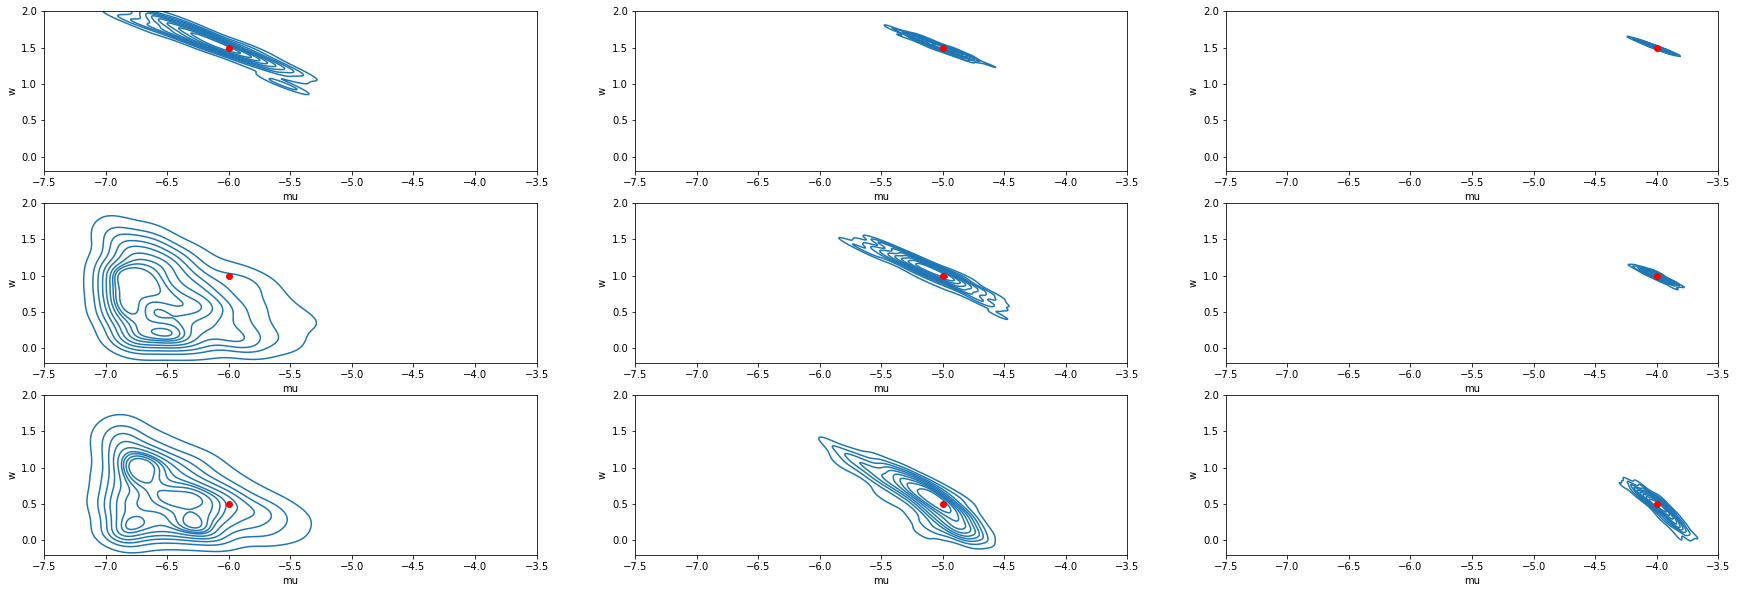

In [12]:
fig, axes = plt.subplots(figsize=(30,10), ncols=3, nrows=3)
xs = [-6, -5, -4]
ys = [1.5, 1, 0.5]
for x in range(3):
    for y in range(3):
        infer(xs[x], ys[y], axes[y][x], 0.00005)

0    0.000000
1    0.000011
2    0.000022
3    0.000046
4    0.000081
5    0.000120
6    0.000205
7    0.000329
8    0.000485
9    0.000736
dtype: float64

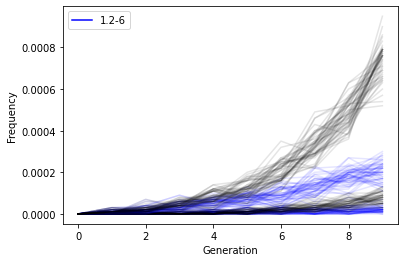

In [41]:
params = {'gen': 10, 'freq0':0, 'pop': 100000000, 'ss': 100000}
mutation_rate = -6
fitness = 1.2
simulate_50(generations_number=params['gen'], wt_freq=params['freq0'],  mutation_rate=10**mutation_rate,
                       population_size=params['pop'], fitness=fitness, sequence_sample_size=params['ss'], 
                       plot=True, color='blue', label='1.2-6').mean()
fitness = 1.5
simulate_50(generations_number=params['gen'], wt_freq=params['freq0'],  mutation_rate=10**mutation_rate,
                       population_size=params['pop'], fitness=fitness, sequence_sample_size=params['ss'], 
                       plot=True, color='black').mean()

mutation_rate = -5
fitness = 1.2
simulate_50(generations_number=params['gen'], wt_freq=params['freq0'],  mutation_rate=10**mutation_rate,
                       population_size=params['pop'], fitness=fitness, sequence_sample_size=params['ss'], 
                       plot=True, color='blue').mean()
fitness = 1.5
simulate_50(generations_number=params['gen'], wt_freq=params['freq0'],  mutation_rate=10**mutation_rate,
                       population_size=params['pop'], fitness=fitness, sequence_sample_size=params['ss'], 
                       plot=True, color='black').mean()

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=98, start_time=2021-02-15 12:04:37.800540, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Trying to infer mutation rate -6 and fitness 1.5


INFO:Epsilon:initial epsilon is 0.001540599999999982
INFO:ABC:t: 0, eps: 0.001540599999999982.
INFO:ABC:Acceptance rate: 1000 / 2042 = 4.8972e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.0002004000000000001.
INFO:ABC:Acceptance rate: 1000 / 2044 = 4.8924e-01, ESS=9.2541e+02.
INFO:ABC:t: 2, eps: 0.00017170984734664644.
INFO:ABC:Acceptance rate: 1000 / 2223 = 4.4984e-01, ESS=9.3047e+02.
INFO:ABC:t: 3, eps: 0.00013960000000000009.
INFO:ABC:Acceptance rate: 1000 / 2584 = 3.8700e-01, ESS=9.0266e+02.
INFO:ABC:t: 4, eps: 0.0001100000000000001.
INFO:ABC:Acceptance rate: 1000 / 2810 = 3.5587e-01, ESS=8.0813e+02.
INFO:ABC:t: 5, eps: 9.000000000000009e-05.
INFO:ABC:Acceptance rate: 1000 / 3782 = 2.6441e-01, ESS=7.6902e+02.
INFO:ABC:t: 6, eps: 7.559999999999997e-05.
INFO:ABC:Acceptance rate: 1000 / 5643 = 1.7721e-01, ESS=5.0475e+02.
INFO:ABC:t: 7, eps: 6.520000000000001e-05.
INFO:ABC:Acceptance rate: 1000 / 10779 = 9.2773e-02, ESS=5.9952e+02.
INFO:ABC:t: 8, eps: 5.640000000000004e-05.
INFO:ABC:Accep

SMC run time:  215.3
Total number of SMC simulations:  476892


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=99, start_time=2021-02-15 12:08:14.048471, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Trying to infer mutation rate -6 and fitness 1


INFO:Epsilon:initial epsilon is 0.001645599999999997
INFO:ABC:t: 0, eps: 0.001645599999999997.
INFO:ABC:Acceptance rate: 1000 / 2041 = 4.8996e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 7.659999999999986e-05.
INFO:ABC:Acceptance rate: 1000 / 2135 = 4.6838e-01, ESS=9.3247e+02.
INFO:ABC:t: 2, eps: 5.040000000000002e-05.
INFO:ABC:Acceptance rate: 1000 / 1570 = 6.3694e-01, ESS=9.3343e+02.
INFO:ABC:t: 3, eps: 4.880000000000002e-05.
INFO:ABC:Acceptance rate: 1000 / 2774 = 3.6049e-01, ESS=7.5956e+02.
INFO:ABC:t: 4, eps: 4.2000000000000004e-05.
INFO:ABC:Acceptance rate: 1000 / 4598 = 2.1749e-01, ESS=8.0312e+02.
INFO:ABC:t: 5, eps: 3.9600000000000014e-05.
INFO:ABC:Acceptance rate: 1000 / 7556 = 1.3235e-01, ESS=7.2158e+02.
INFO:ABC:t: 6, eps: 3.5999999999999994e-05.
INFO:ABC:Acceptance rate: 1000 / 11756 = 8.5063e-02, ESS=7.5045e+02.
INFO:ABC:t: 7, eps: 3.2000000000000005e-05.
INFO:ABC:Acceptance rate: 1000 / 20650 = 4.8426e-02, ESS=6.1393e+02.
INFO:ABC:t: 8, eps: 3.0400000000000007e-05.
INFO:ABC:A

SMC run time:  212.64
Total number of SMC simulations:  469174


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=100, start_time=2021-02-15 12:11:47.578578, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Trying to infer mutation rate -6 and fitness 0.5


INFO:Epsilon:initial epsilon is 0.0016881999999999971
INFO:ABC:t: 0, eps: 0.0016881999999999971.
INFO:ABC:Acceptance rate: 1000 / 2037 = 4.9092e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 9.179999999999986e-05.
INFO:ABC:Acceptance rate: 1000 / 2097 = 4.7687e-01, ESS=9.5055e+02.
INFO:ABC:t: 2, eps: 3.04e-05.
INFO:ABC:Acceptance rate: 1000 / 2032 = 4.9213e-01, ESS=9.5705e+02.
INFO:ABC:t: 3, eps: 1.8e-05.
INFO:ABC:Acceptance rate: 1000 / 2284 = 4.3783e-01, ESS=9.1163e+02.
INFO:ABC:t: 4, eps: 1.8e-05.
INFO:ABC:Acceptance rate: 1000 / 1824 = 5.4825e-01, ESS=6.7094e+02.
INFO:ABC:t: 5, eps: 1.8e-05.
INFO:ABC:Acceptance rate: 1000 / 1803 = 5.5463e-01, ESS=7.5973e+02.
INFO:ABC:t: 6, eps: 1.8e-05.
INFO:ABC:Acceptance rate: 1000 / 1768 = 5.6561e-01, ESS=5.8908e+02.
INFO:ABC:t: 7, eps: 1.8e-05.
INFO:ABC:Acceptance rate: 1000 / 1846 = 5.4171e-01, ESS=7.2822e+02.
INFO:ABC:t: 8, eps: 1.8e-05.
INFO:ABC:Acceptance rate: 1000 / 1838 = 5.4407e-01, ESS=7.3494e+02.
INFO:ABC:t: 9, eps: 1.8e-05.
INFO:ABC:Accept

SMC run time:  31.5
Total number of SMC simulations:  26078


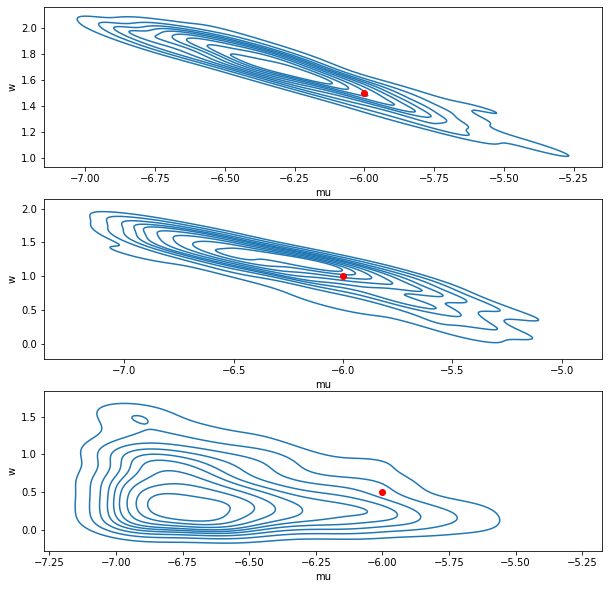

In [13]:
fig, axes = plt.subplots(figsize=(10,10), ncols=1, nrows=3)
xs = [-6]
ys = [1.5, 1, 0.5]
for x in xs:
    for y in ys:
        infer(x, y, axes[ys.index(y)], 0.00001, 13)

In [ ]:
fig, axes = plt.subplots(figsize=(20,10), ncols=3, nrows=3)
xs = [-6, -5, -4]
ys = [1.5, 1, 0.5]
for x in range(3):
    for y in range(3):
        infer(xs[x], ys[y], axes[y][x], 0.00005)

In [18]:
df

NameError: name 'df' is not defined

In [19]:
df, df['weights'] = post.get_distribution()

In [20]:
df

name,mu,w,weights
id,,,
439089,-4.003719,1.199568,0.000695
439090,-4.045552,1.229340,0.000703
439091,-3.848928,1.097721,0.001346
439092,-3.924895,1.161859,0.000914
439093,-3.953050,1.174395,0.000746
...,...,...,...
440084,-4.165627,1.308432,0.001469
440085,-4.039426,1.206441,0.000865
440086,-4.031062,1.214516,0.000720


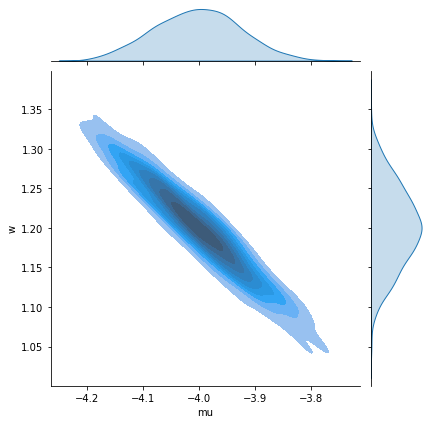

In [30]:
sns.jointplot(data=df, x='mu', y='w', kind='kde', weights=df['weights'], fill=True)


INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=47, start_time=2021-02-15 10:59:06.773523, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...


INFO:Epsilon:initial epsilon is 0.0013779999999999964
INFO:ABC:t: 0, eps: 0.0013779999999999964.
INFO:ABC:Acceptance rate: 1000 / 2017 = 4.9579e-01, ESS=1.0000e+03.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=47, start_time=2021-02-15 10:59:06.773523, end_time=2021-02-15 10:59:08.933872)>


SMC run time:  2.19
Total number of SMC simulations:  3017


/home/itush/miniconda3/lib/python3.7/site-packages/pyabc/visualization/kde.py:350: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = ax.pcolormesh(X, Y, PDF, **kwargs)


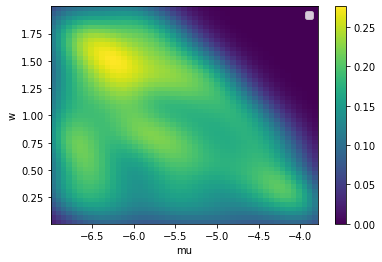

AttributeError: 'float' object has no attribute 'plot'

In [119]:
post = infer(-5, 0.8, 0.0001)

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=24, start_time=2021-02-15 10:49:47.580581, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Running SMC with epsilon:  0.0005


INFO:Epsilon:initial epsilon is 0.0013919999999999805
INFO:ABC:t: 0, eps: 0.0013919999999999805.
INFO:ABC:Acceptance rate: 1000 / 2033 = 4.9188e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00026500000000000015.
INFO:ABC:Acceptance rate: 1000 / 1794 = 5.5741e-01, ESS=9.7816e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=24, start_time=2021-02-15 10:49:47.580581, end_time=2021-02-15 10:49:51.474445)>


SMC run time:  3.91
Total number of SMC simulations:  4827


/home/itush/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:437: UserWarning: The following kwargs were not used by contour: 'weights'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)
INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=25, start_time=2021-02-15 10:49:52.348735, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Running SMC with epsilon:  0.0005


INFO:Epsilon:initial epsilon is 0.0010680000000000004
INFO:ABC:t: 0, eps: 0.0010680000000000004.
INFO:ABC:Acceptance rate: 1000 / 1957 = 5.1099e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.0009525999999999992.
INFO:ABC:Acceptance rate: 1000 / 2174 = 4.5998e-01, ESS=9.5775e+02.
INFO:ABC:t: 2, eps: 0.0007427502781490223.
INFO:ABC:Acceptance rate: 1000 / 2156 = 4.6382e-01, ESS=9.6774e+02.
INFO:ABC:t: 3, eps: 0.0005645970726516403.
INFO:ABC:Acceptance rate: 1000 / 2210 = 4.5249e-01, ESS=9.6235e+02.
INFO:ABC:t: 4, eps: 0.0004272000000000001.
INFO:ABC:Acceptance rate: 1000 / 2237 = 4.4703e-01, ESS=9.3441e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=25, start_time=2021-02-15 10:49:52.348735, end_time=2021-02-15 10:50:02.389678)>


SMC run time:  10.06
Total number of SMC simulations:  11734


/home/itush/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:437: UserWarning: The following kwargs were not used by contour: 'weights'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)
INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=26, start_time=2021-02-15 10:50:03.339169, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Running SMC with epsilon:  0.0005


INFO:Epsilon:initial epsilon is 0.027518799999999996
INFO:ABC:t: 0, eps: 0.027518799999999996.
INFO:ABC:Acceptance rate: 1000 / 1911 = 5.2329e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.025308799999999996.
INFO:ABC:Acceptance rate: 1000 / 2140 = 4.6729e-01, ESS=9.5014e+02.
INFO:ABC:t: 2, eps: 0.01915502708897848.
INFO:ABC:Acceptance rate: 1000 / 2067 = 4.8379e-01, ESS=9.5095e+02.
INFO:ABC:t: 3, eps: 0.013832999999999998.
INFO:ABC:Acceptance rate: 1000 / 2143 = 4.6664e-01, ESS=9.8004e+02.
INFO:ABC:t: 4, eps: 0.009207912297031854.
INFO:ABC:Acceptance rate: 1000 / 2127 = 4.7015e-01, ESS=9.8872e+02.
INFO:ABC:t: 5, eps: 0.006980142372031966.
INFO:ABC:Acceptance rate: 1000 / 2002 = 4.9950e-01, ESS=9.8493e+02.
INFO:ABC:t: 6, eps: 0.005294075074071644.
INFO:ABC:Acceptance rate: 1000 / 2104 = 4.7529e-01, ESS=9.9064e+02.
INFO:ABC:t: 7, eps: 0.00389320400430487.
INFO:ABC:Acceptance rate: 1000 / 2058 = 4.8591e-01, ESS=9.8928e+02.
INFO:ABC:t: 8, eps: 0.0028847374965319315.
INFO:ABC:Acceptance rate: 

SMC run time:  21.04
Total number of SMC simulations:  21908


/home/itush/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:437: UserWarning: The following kwargs were not used by contour: 'weights'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)
INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=27, start_time=2021-02-15 10:50:25.248754, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Creating dataset...
Running SMC with epsilon:  0.0005


INFO:Epsilon:initial epsilon is 0.10621579999999999
INFO:ABC:t: 0, eps: 0.10621579999999999.
INFO:ABC:Acceptance rate: 1000 / 1905 = 5.2493e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.09621579999999996.
INFO:ABC:Acceptance rate: 1000 / 2202 = 4.5413e-01, ESS=9.6485e+02.
INFO:ABC:t: 2, eps: 0.07250591574053117.
INFO:ABC:Acceptance rate: 1000 / 2121 = 4.7148e-01, ESS=9.4657e+02.
INFO:ABC:t: 3, eps: 0.055524000964460245.
INFO:ABC:Acceptance rate: 1000 / 1991 = 5.0226e-01, ESS=9.7622e+02.
INFO:ABC:t: 4, eps: 0.041069066095007344.
INFO:ABC:Acceptance rate: 1000 / 1949 = 5.1308e-01, ESS=9.9145e+02.
INFO:ABC:t: 5, eps: 0.030389111946650477.
INFO:ABC:Acceptance rate: 1000 / 2076 = 4.8170e-01, ESS=9.8801e+02.
INFO:ABC:t: 6, eps: 0.02203701140946072.
INFO:ABC:Acceptance rate: 1000 / 2007 = 4.9826e-01, ESS=9.9468e+02.
INFO:ABC:t: 7, eps: 0.015631054084720337.
INFO:ABC:Acceptance rate: 1000 / 2057 = 4.8614e-01, ESS=9.9555e+02.
INFO:ABC:t: 8, eps: 0.011222870352587289.
INFO:ABC:Acceptance rate: 1000

SMC run time:  22.42
Total number of SMC simulations:  21468


/home/itush/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:437: UserWarning: The following kwargs were not used by contour: 'weights'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


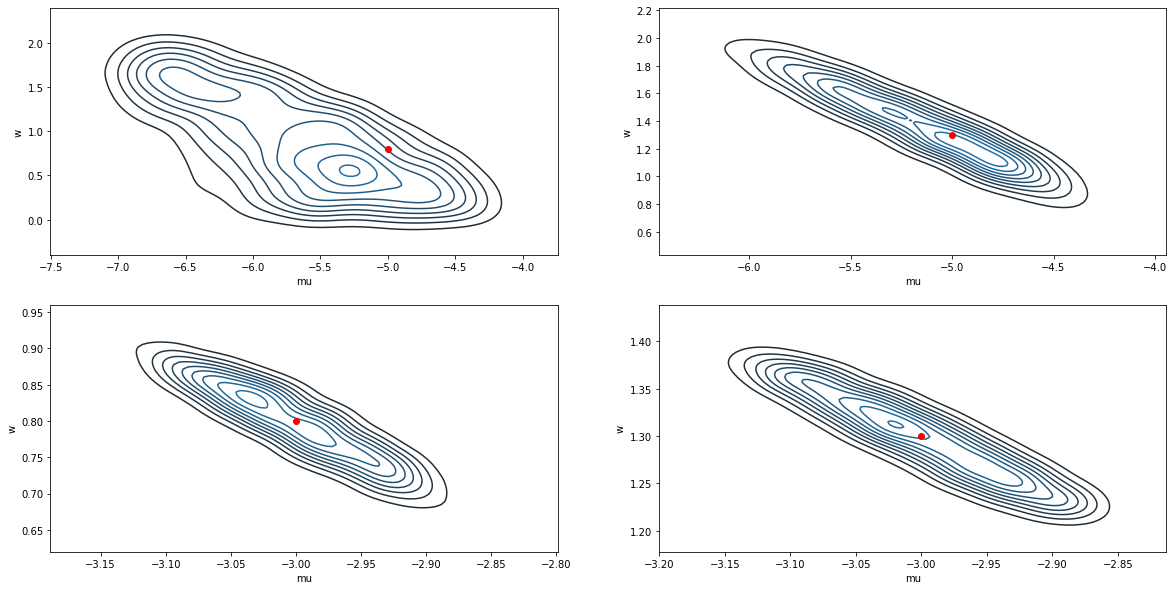

In [107]:
fig, axes = plt.subplots(figsize=(20,10), ncols=2, nrows=2)
infer(-5, 0.8, axes[0][0], 0.0005)
infer(-5, 1.3, axes[0][1], 0.0005)
infer(-3, 0.8, axes[1][0], 0.0005)
infer(-3, 1.3, axes[1][1], 0.0005)